In [3]:
# ! jt -r
# !jt -t oceans16 -T -N -kl
# !jt -l

# Introduction

>🚀 **I’ve worked a few years in the energy sector, that is the reason why I decided to mix my previous experience with the field of my becoming one (I hope so, you tell me).  
🚀 The idea is to tackle a real-world problem by working with a dataset of household electricity consumption and production data, made available by the Belgian distribution system operator Fluvius. This data was measured with the digital meter rolled out by Fluvius.  
🚀 Plus, I thought it would be interesting to deal with Time Series**

# Imports

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.dates import MonthLocator
import seaborn as sns
import numpy as np
import holidays

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso

from sklearn.model_selection import learning_curve, GridSearchCV, RandomizedSearchCV, train_test_split, cross_validate, cross_val_score
from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder

from sklearn.metrics import ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

from sklearn.pipeline import make_pipeline, make_union, FeatureUnion
from sklearn import set_config

set_config(display='diagram')

from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

"""TS packages"""
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

"""DL Model"""
import keras
from keras.layers import Dense, LSTM, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical, np_utils
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
import itertools
from tensorflow.keras import regularizers, Sequential, layers
import tensorflow
from tensorflow.keras.models import save_model, load_model

> The dataset can be downloaded 👉 [here](https://opendata.fluvius.be/explore/dataset/1_50-aanlevering-dmk-e-kwartierwaarden/information/)  
> **File names** : 1.50Aanlevering DMK-E-Kwartierwaarden.zip > P6269-1.50-Aanlevering-DMK-E-Kwartierwaarden.csv

In [73]:
url = "/mnt/c/Users/qwout/Documents/Emplois/Thermovault/1.50Aanlevering DMK-E-Kwartierwaarden/P6269-1.50-Aanlevering-DMK-E-Kwartierwaarden.csv"
data = pd.read_csv(url)
data = data.copy()
# Display (set_option)/Not display (reset_option) all columns
# pd.reset_option('display.max_columns', None)
display(data.info())
print('Glimpse of the raw data :')
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504000 entries, 0 to 3503999
Data columns (total 5 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   EAN_ID                 int64  
 1   ReadStartDate          object 
 2   ReadStartDateTime      object 
 3   VolumeAfname_TH_kWh    float64
 4   VolumeInjectie_TH_kWh  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 133.7+ MB


None

Glimpse of the raw data :


EAN_ID ReadStartDate         ReadStartDateTime  VolumeAfname_TH_kWh  \
0             1    2021-01-01  2021-01-01T00:00:00.000Z                0.076   
1             1    2021-01-01  2021-01-01T00:15:00.000Z                0.048   
2             1    2021-01-01  2021-01-01T00:30:00.000Z                0.038   
3             1    2021-01-01  2021-01-01T00:45:00.000Z                0.317   
4             1    2021-01-01  2021-01-01T01:00:00.000Z                0.570   
...         ...           ...                       ...                  ...   
3503995     100    2021-12-31  2021-12-31T22:45:00.000Z                0.153   
3503996     100    2021-12-31  2021-12-31T23:00:00.000Z                0.122   
3503997     100    2021-12-31  2021-12-31T23:15:00.000Z                0.139   
3503998     100    2021-12-31  2021-12-31T23:30:00.000Z                0.170   
3503999     100    2021-12-31  2021-12-31T23:45:00.000Z                0.155   

         VolumeInjectie_TH_kWh  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          0.0  
...                        ...  
3503995                    0.0  
3503996                    0.0  
3503997                    0.0  
3503998                    0.0  
3503999                    0.0  

[3504000 rows x 5 columns]

# Data preparation

## Select list of EANs

In [74]:
"""Select the EAN [1, 2, 3, 4, 5, 14, 16, 17, 19], no taking into account the TZ """
data_EAN = data[data['EAN_ID'].isin([1, 2, 3, 4, 5, 14, 16, 17,19])] #Selected households EANGSRN
data_EAN.drop(columns=['ReadStartDate'], inplace = True) # No need this column
data_EAN['ReadStartDateTime'] = data_EAN['ReadStartDateTime'].apply(lambda x: x[:-5]) # Let's do not take the TimeZone into account
data_EAN['ReadStartDateTime'] = pd.to_datetime(data_EAN['ReadStartDateTime'])  # Convert to datetime
data_EAN.reset_index(drop=True, inplace=True)  # drop = True : does not add the new column of the current row index in the DF
display(data_EAN)
display(data_EAN.info())

/tmp/ipykernel_1801/1240184269.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_EAN.drop(columns=['ReadStartDate'], inplace = True) # No need this column
/tmp/ipykernel_1801/1240184269.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_EAN['ReadStartDateTime'] = data_EAN['ReadStartDateTime'].apply(lambda x: x[:-5]) # Let's do not take the TimeZone into account
/tmp/ipykernel_1801/1240184269.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh
0            1 2021-01-01 00:00:00                0.076                    0.0
1            1 2021-01-01 00:15:00                0.048                    0.0
2            1 2021-01-01 00:30:00                0.038                    0.0
3            1 2021-01-01 00:45:00                0.317                    0.0
4            1 2021-01-01 01:00:00                0.570                    0.0
...        ...                 ...                  ...                    ...
315355      19 2021-12-31 22:45:00                0.360                    0.0
315356      19 2021-12-31 23:00:00                0.475                    0.0
315357      19 2021-12-31 23:15:00                0.168                    0.0
315358      19 2021-12-31 23:30:00                0.407                    0.0
315359      19 2021-12-31 23:45:00                0.148                    0.0

[315360 rows x 4 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315360 entries, 0 to 315359
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   EAN_ID                 315360 non-null  int64         
 1   ReadStartDateTime      315360 non-null  datetime64[ns]
 2   VolumeAfname_TH_kWh    315360 non-null  float64       
 3   VolumeInjectie_TH_kWh  315360 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 9.6 MB


None

## EDA - Let's do some checks

### All 1/4h of the year are there for each EAN (96x356 = 35040)

In [75]:
print(data_EAN.EAN_ID.value_counts()) 

1     35040
2     35040
3     35040
4     35040
5     35040
14    35040
16    35040
17    35040
19    35040
Name: EAN_ID, dtype: int64


In [76]:
display(data_EAN.EAN_ID.unique()) # Check unique values in EAN_ID, if are the one selected

array([ 1,  2,  3,  4,  5, 14, 16, 17, 19])

### Missing Values

In [77]:
print(data_EAN.isna().sum())

EAN_ID                   0
ReadStartDateTime        0
VolumeAfname_TH_kWh      0
VolumeInjectie_TH_kWh    0
dtype: int64


### Null values

In [78]:
'''# NaN percentage for each column'''
print(data_EAN.shape)
round(data_EAN.isnull().sum().sort_values(ascending=False) / len(data_EAN), 2)

(315360, 4)


EAN_ID                   0.0
ReadStartDateTime        0.0
VolumeAfname_TH_kWh      0.0
VolumeInjectie_TH_kWh    0.0
dtype: float64

In [79]:
"""In a previous cell, there are no null values, which is NOT true"""
display(data_EAN['VolumeAfname_TH_kWh'].value_counts())
display(data_EAN['VolumeInjectie_TH_kWh'].value_counts())

0.000000    37240
0.025000     3519
0.024000     3451
0.045000     3447
0.049000     3252
            ...  
0.089041        1
0.047231        1
0.065813        1
0.077272        1
1.582000        1
Name: VolumeAfname_TH_kWh, Length: 8681, dtype: int64

0.000000    256376
0.003000      2342
0.002000      1873
0.001000      1769
0.004000      1581
             ...  
0.017950         1
0.020253         1
0.017977         1
0.018956         1
0.004500         1
Name: VolumeInjectie_TH_kWh, Length: 1213, dtype: int64

In [80]:
"""List of detailed values I want to check"""
mis_val = data_EAN.isin([pd.NA, np.nan, None, '-', 'N/A', 0]).sum()
mis_val

EAN_ID                        0
ReadStartDateTime             0
VolumeAfname_TH_kWh       37240
VolumeInjectie_TH_kWh    256376
dtype: int64

In [81]:
"""Detailed values found in each column of DF"""
values_to_check = [pd.NA, np.nan, None, '-', 'N/A', 0]
value_details = {}

# Iterate through each column
for col in data_EAN.columns:
    col_values = data_EAN[col]
    value_info = {}
    for value in values_to_check:
        count = (col_values == value).sum()
        value_info[str(value)] = count
    value_details[col] = value_info

# Display the detailed information about specified values
print("Detailed information about specified values:")
for col, info in value_details.items():
    print(f"{col}: {info}")

Detailed information about specified values:
EAN_ID: {'<NA>': 0, 'nan': 0, 'None': 0, '-': 0, 'N/A': 0, '0': 0}
ReadStartDateTime: {'<NA>': 0, 'nan': 0, 'None': 0, '-': 0, 'N/A': 0, '0': 0}
VolumeAfname_TH_kWh: {'<NA>': 0, 'nan': 0, 'None': 0, '-': 0, 'N/A': 0, '0': 37240}
VolumeInjectie_TH_kWh: {'<NA>': 0, 'nan': 0, 'None': 0, '-': 0, 'N/A': 0, '0': 256376}


### Duplicates

In [82]:
"""Correct number of values for each EAN (see above), 
which means 96 (quarter of an hour per day) x 356 (days of the year 2021) = 35040 values
NO duplicates"""

duplicate_count = data_EAN.duplicated().sum()
print(f'Number of duplicates {duplicate_count}')
print('% of duplicates is', duplicate_count / len(data_EAN) * 100, '%')

Number of duplicates 0
% of duplicates is 0.0 %


# Features creation (Panel Data)

Panel Data : 
> - Panel data is also a time based dataset. The difference is that, in addition to time series, it also contains one or more related variables that are measured for the same time periods.  
> - Typically, the columns present in panel data contain explanatory variables that can be helpful in predicting the Y, provided those columns will be available at the future forecasting period.

## Creation of hour, day, week, week-end, month, quarter and year features

In [83]:
data_EAN = data_EAN.copy()
def features_creation(df):
#     Create a new column 'week_day' that indicates if the day is a weekday or week-end
#     (Monday=0 to Friday=5) & week-end days (Saturday = 6, Sunday = 7)
#     Reason : for TimeFrame HI/LO function and day of week or week-end
    df['week_day'] = df['ReadStartDateTime'].dt.weekday
    # Creayte cOlumn indicating if day of the week or day of the week-end 
    df['week_day/wee_end_day'] = df['week_day'].apply(lambda x: 'week_end' if x > 5 else 'week_day')
    df['hour'] = df.ReadStartDateTime.dt.hour
    df['day'] = df.ReadStartDateTime.dt.day
#     df['is_holiday'] = df['ReadStartDateTime'].apply(lambda x: int(x in holidays.BE())) # Takes to much time (try Dask) 
    df['month'] = df.ReadStartDateTime.dt.month
    df['quarter'] = df.ReadStartDateTime.dt.quarter
    df['year'] = df.ReadStartDateTime.dt.year
    
    return df

In [84]:
features_creation(data_EAN)

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1 2021-01-01 00:00:00                0.076   
1            1 2021-01-01 00:15:00                0.048   
2            1 2021-01-01 00:30:00                0.038   
3            1 2021-01-01 00:45:00                0.317   
4            1 2021-01-01 01:00:00                0.570   
...        ...                 ...                  ...   
315355      19 2021-12-31 22:45:00                0.360   
315356      19 2021-12-31 23:00:00                0.475   
315357      19 2021-12-31 23:15:00                0.168   
315358      19 2021-12-31 23:30:00                0.407   
315359      19 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  week_day week_day/wee_end_day  hour  day  \
0                         0.0         4             week_day     0    1   
1                         0.0         4             week_day     0    1   
2                         0.0         4             week_day     0    1   
3                         0.0         4             week_day     0    1   
4                         0.0         4             week_day     1    1   
...                       ...       ...                  ...   ...  ...   
315355                    0.0         4             week_day    22   31   
315356                    0.0         4             week_day    23   31   
315357                    0.0         4             week_day    23   31   
315358                    0.0         4             week_day    23   31   
315359                    0.0         4             week_day    23   31   

        month  quarter  year  
0           1        1  2021  
1           1        1  2021  
2           1        1  2021  
3           1        1  2021  
4           1        1  2021  
...       ...      ...   ...  
315355     12        4  2021  
315356     12        4  2021  
315357     12        4  2021  
315358     12        4  2021  
315359     12        4  2021  

[315360 rows x 11 columns]

## Creation of time frame HI/LO

In [85]:
def time_frame(row):
    if (6 <= row['hour'] < 22) and (row['week_day'] <= 5):
        return 'HI'
    else:
        return 'LO'  # You can choose what to do in other cases

In [86]:
# Apply the time_frame function to create the 'Time_frame' HI/LO column
data_EAN['Time_Frame'] = data_EAN.apply(time_frame, axis=1)
data_EAN

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1 2021-01-01 00:00:00                0.076   
1            1 2021-01-01 00:15:00                0.048   
2            1 2021-01-01 00:30:00                0.038   
3            1 2021-01-01 00:45:00                0.317   
4            1 2021-01-01 01:00:00                0.570   
...        ...                 ...                  ...   
315355      19 2021-12-31 22:45:00                0.360   
315356      19 2021-12-31 23:00:00                0.475   
315357      19 2021-12-31 23:15:00                0.168   
315358      19 2021-12-31 23:30:00                0.407   
315359      19 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  week_day week_day/wee_end_day  hour  day  \
0                         0.0         4             week_day     0    1   
1                         0.0         4             week_day     0    1   
2                         0.0         4             week_day     0    1   
3                         0.0         4             week_day     0    1   
4                         0.0         4             week_day     1    1   
...                       ...       ...                  ...   ...  ...   
315355                    0.0         4             week_day    22   31   
315356                    0.0         4             week_day    23   31   
315357                    0.0         4             week_day    23   31   
315358                    0.0         4             week_day    23   31   
315359                    0.0         4             week_day    23   31   

        month  quarter  year Time_Frame  
0           1        1  2021         LO  
1           1        1  2021         LO  
2           1        1  2021         LO  
3           1        1  2021         LO  
4           1        1  2021         LO  
...       ...      ...   ...        ...  
315355     12        4  2021         LO  
315356     12        4  2021         LO  
315357     12        4  2021         LO  
315358     12        4  2021         LO  
315359     12        4  2021         LO  

[315360 rows x 12 columns]

In [87]:
""" See cell RESAMPLING BY DAY for the explaination of more Fridays (day 4 of the week) in 2021"""
data_EAN['ReadStartDateTime'].dt.dayofweek.value_counts()

4    45792
5    44928
6    44928
0    44928
1    44928
2    44928
3    44928
Name: ReadStartDateTime, dtype: int64

## Feature Importance

### Correlation Analysis - Heatmap

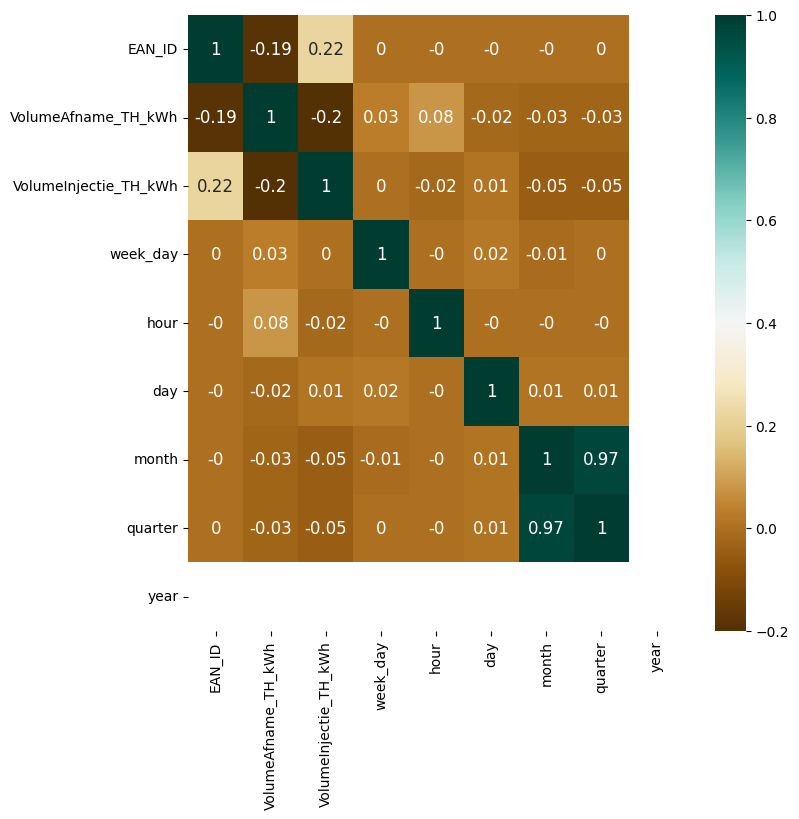

In [90]:
plt.figure(figsize = (8,8))
sns.heatmap(round(data_EAN.corr(),2), cmap = "BrBG", annot = True, annot_kws = {"size":12});

>  We can see that, for the consumption (VolumeAfname_TH_kWh), the EAN and the hour are the most influential features in our model. Here we don't take into account the injection (VolumeInjectie_TH_kWh). Injection and consumption must be considered separately.

# Graph representations

> Now that we have created additional features, let’s visualize the relationship between these features and the electricity consumption. We could ask ourselves the following questions : 
>- How does the production or consumption vary across households?
>- How do the production and consumption of electricity vary over the year?
>- Do you observe any further patterns in the data?

## Distribution of electricity consumption across different hours of the day

### Resampling

> 1. Resampling by month, date or time is very important because it has a great interaction as expected (changing the periodicity of the system).  
> 2. Therefore, if you process all the original data, the run time will be very expensive, but if you process data with large timescale samples (e.g., monthly), it will affect the predictability of the model.  
> 3. From observation (graph below), we can see it is relatively reasonable to resample the data per hour.  

In [51]:
"""Set/Reset dates as index before resampling"""
# data_EAN.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_EAN.reset_index(inplace=True) # Comment/uncomment this row or the previous one
data_EAN

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1 2021-01-01 00:00:00                0.076   
1            1 2021-01-01 00:15:00                0.048   
2            1 2021-01-01 00:30:00                0.038   
3            1 2021-01-01 00:45:00                0.317   
4            1 2021-01-01 01:00:00                0.570   
...        ...                 ...                  ...   
315355      19 2021-12-31 22:45:00                0.360   
315356      19 2021-12-31 23:00:00                0.475   
315357      19 2021-12-31 23:15:00                0.168   
315358      19 2021-12-31 23:30:00                0.407   
315359      19 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  week_day week_day/wee_end_day  hour  day  \
0                         0.0         4             week_day     0    1   
1                         0.0         4             week_day     0    1   
2                         0.0         4             week_day     0    1   
3                         0.0         4             week_day     0    1   
4                         0.0         4             week_day     1    1   
...                       ...       ...                  ...   ...  ...   
315355                    0.0         4             week_day    22   31   
315356                    0.0         4             week_day    23   31   
315357                    0.0         4             week_day    23   31   
315358                    0.0         4             week_day    23   31   
315359                    0.0         4             week_day    23   31   

        month  quarter  year Time_Frame  
0           1        1  2021         LO  
1           1        1  2021         LO  
2           1        1  2021         LO  
3           1        1  2021         LO  
4           1        1  2021         LO  
...       ...      ...   ...        ...  
315355     12        4  2021         LO  
315356     12        4  2021         LO  
315357     12        4  2021         LO  
315358     12        4  2021         LO  
315359     12        4  2021         LO  

[315360 rows x 12 columns]

Infos important for the chaining functions of the next cell : 
> - If group by weeks : 9 EANs * 53 weeks = 447 rowss
> - If group by hour : 9 EANs * 8760 hours in a year = 78 840
> - groupby : 
> -- EANs
> -- pd.Grouper on the dates by hourly frequence (S: Seconds, min: Minutes, H: Hours, D: Day, W: Week, M: Month, Q: Quarter or A: Year)
> - agg precise which funtion apply on which column  
> - reset_index() "ungroupedby" in order to have a value (of EAN and date) for each row

#### By hours

In [91]:
data_resample_h = data_EAN.groupby(['EAN_ID',
                                    pd.Grouper(key='ReadStartDateTime', axis=0, freq='H')]).agg({
                                                        'VolumeAfname_TH_kWh': 'sum',
                                                        'VolumeInjectie_TH_kWh': 'sum'}).reset_index()
data_resample_h

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh
0           1 2021-01-01 00:00:00                0.479                    0.0
1           1 2021-01-01 01:00:00                1.205                    0.0
2           1 2021-01-01 02:00:00                0.248                    0.0
3           1 2021-01-01 03:00:00                0.204                    0.0
4           1 2021-01-01 04:00:00                0.191                    0.0
...       ...                 ...                  ...                    ...
78835      19 2021-12-31 19:00:00                1.624                    0.0
78836      19 2021-12-31 20:00:00                1.910                    0.0
78837      19 2021-12-31 21:00:00                0.836                    0.0
78838      19 2021-12-31 22:00:00                1.122                    0.0
78839      19 2021-12-31 23:00:00                1.198                    0.0

[78840 rows x 4 columns]

> 👇 Let's have a look at the features after having resampled by hours (doesn't change much)

In [92]:
data_resample_h_features = features_creation(data_resample_h)
data_resample_h_features['Time_Frame'] = data_resample_h_features.apply(time_frame, axis=1)
data_resample_h_features

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0           1 2021-01-01 00:00:00                0.479                    0.0   
1           1 2021-01-01 01:00:00                1.205                    0.0   
2           1 2021-01-01 02:00:00                0.248                    0.0   
3           1 2021-01-01 03:00:00                0.204                    0.0   
4           1 2021-01-01 04:00:00                0.191                    0.0   
...       ...                 ...                  ...                    ...   
78835      19 2021-12-31 19:00:00                1.624                    0.0   
78836      19 2021-12-31 20:00:00                1.910                    0.0   
78837      19 2021-12-31 21:00:00                0.836                    0.0   
78838      19 2021-12-31 22:00:00                1.122                    0.0   
78839      19 2021-12-31 23:00:00                1.198                    0.0   

       week_day week_day/wee_end_day  hour  day  month  quarter  year  \
0             4             week_day     0    1      1        1  2021   
1             4             week_day     1    1      1        1  2021   
2             4             week_day     2    1      1        1  2021   
3             4             week_day     3    1      1        1  2021   
4             4             week_day     4    1      1        1  2021   
...         ...                  ...   ...  ...    ...      ...   ...   
78835         4             week_day    19   31     12        4  2021   
78836         4             week_day    20   31     12        4  2021   
78837         4             week_day    21   31     12        4  2021   
78838         4             week_day    22   31     12        4  2021   
78839         4             week_day    23   31     12        4  2021   

      Time_Frame  
0             LO  
1             LO  
2             LO  
3             LO  
4             LO  
...          ...  
78835         HI  
78836         HI  
78837         HI  
78838         LO  
78839         LO  

[78840 rows x 12 columns]

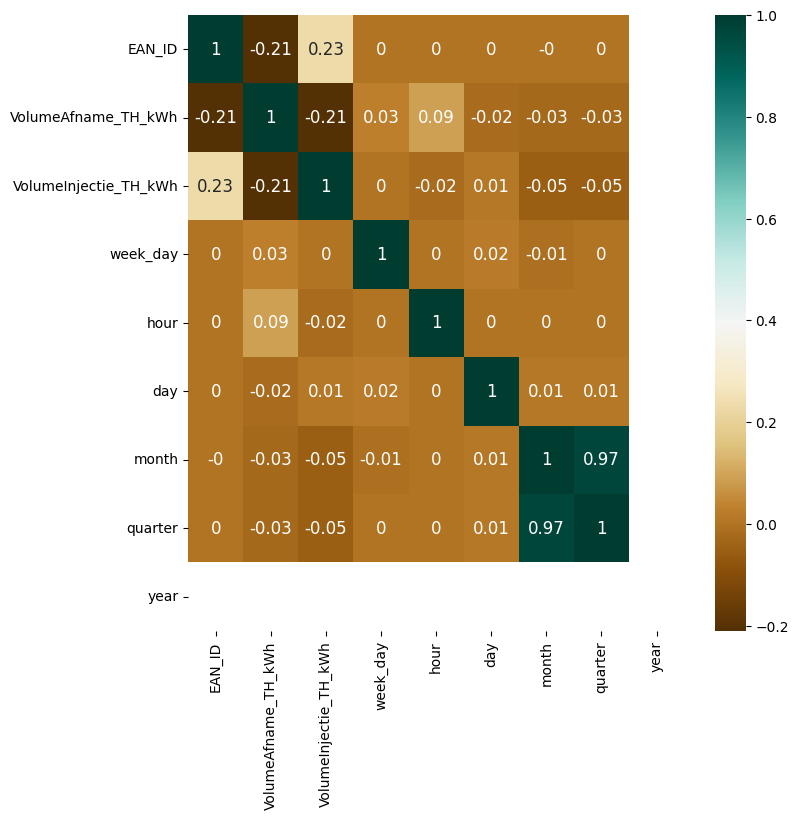

In [93]:
plt.figure(figsize = (8,8))
sns.heatmap(round(data_resample_h_features.corr(),2), cmap = "BrBG", annot = True, annot_kws = {"size":12});

#### By Day

In [34]:
data_resample_d = data_EAN.groupby(['EAN_ID',
                                    pd.Grouper(key='ReadStartDateTime', axis=0, freq='D')]).agg({
                                                        'VolumeAfname_TH_kWh': 'sum',
                                                        'VolumeInjectie_TH_kWh': 'sum'}).reset_index()
data_resample_d

EAN_ID ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh
0          1        2021-01-01               19.608                  1.097
1          1        2021-01-02               18.551                  0.576
2          1        2021-01-03               11.107                  0.140
3          1        2021-01-04               21.706                  0.031
4          1        2021-01-05               18.368                  0.000
...      ...               ...                  ...                    ...
3280      19        2021-12-27               14.144                  0.000
3281      19        2021-12-28               11.988                  0.510
3282      19        2021-12-29               13.201                  0.000
3283      19        2021-12-30               14.211                  0.000
3284      19        2021-12-31               18.393                  0.827

[3285 rows x 4 columns]

In [69]:
"""After having resampeled by days, let's focus on EAN 1. We can see that there are 53 Fridays in 2021,
campared to 52 other (Manday, Thesday, Wednesday,...) days. Indeed, January 1st, 2021 is a Friday"""
data_resample_d.loc[data_resample_d['EAN_ID'] == 1]['ReadStartDateTime'].dt.dayofweek.value_counts()

4    53
5    52
6    52
0    52
1    52
2    52
3    52
Name: ReadStartDateTime, dtype: int64

### Graph all EANs by Day

> 📊 Let's make a few visualizations that summarize your findings

#### Consumption

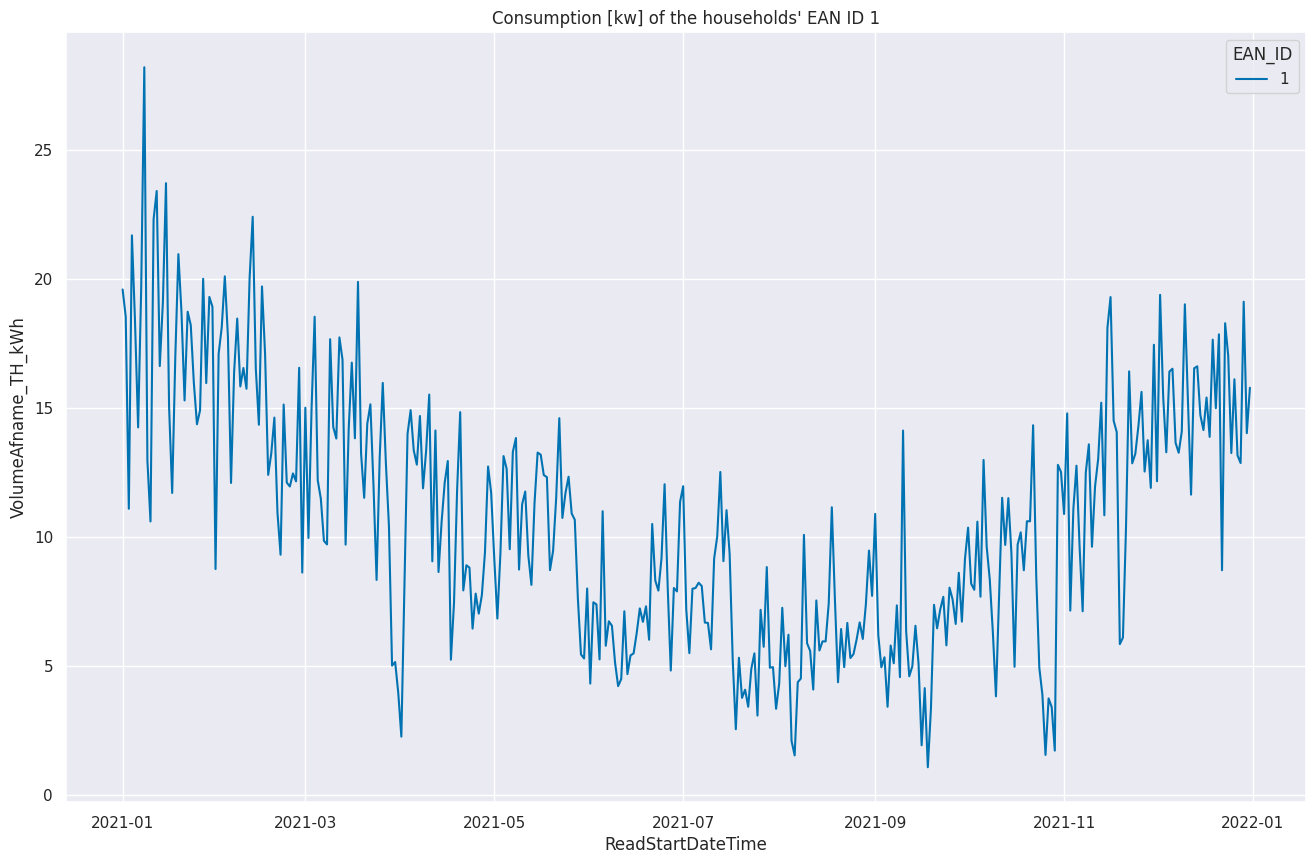

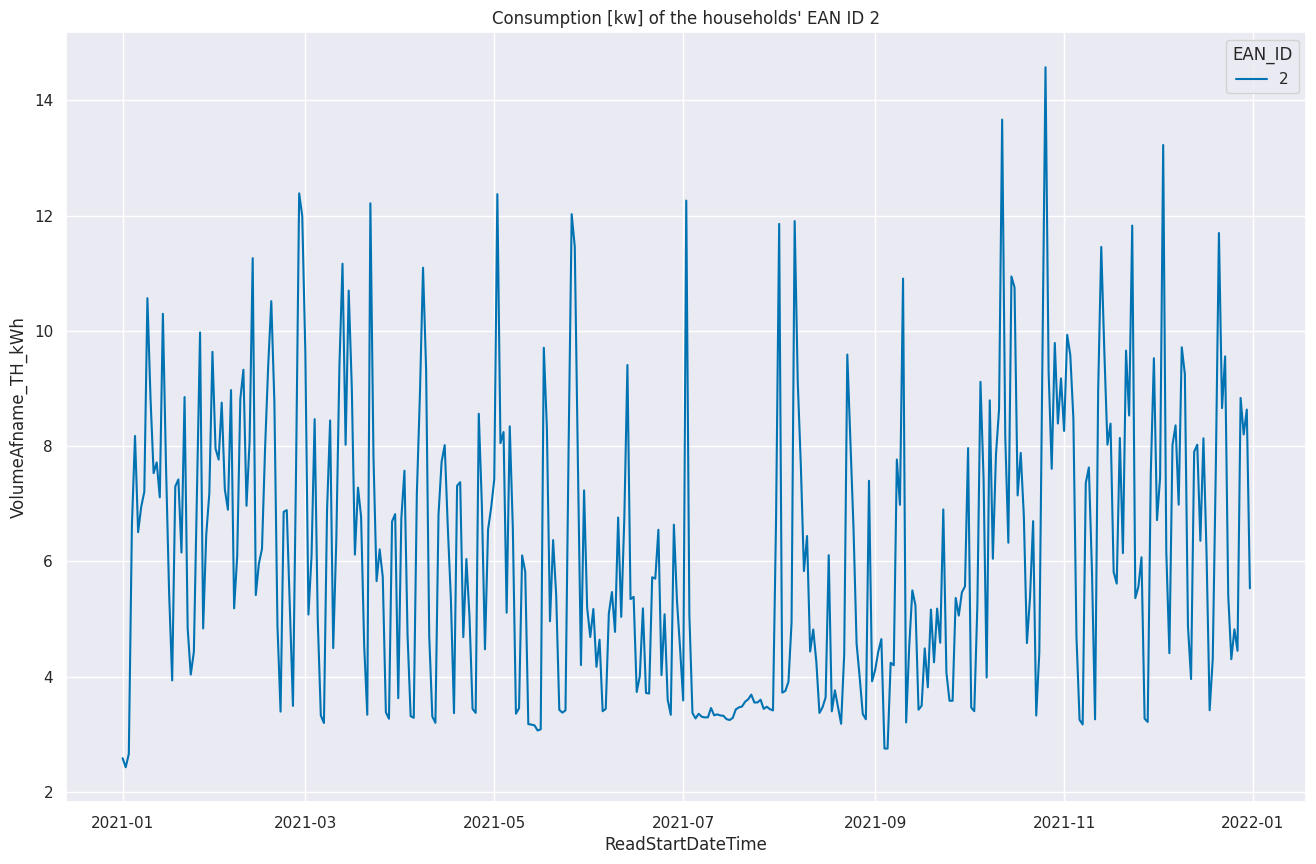

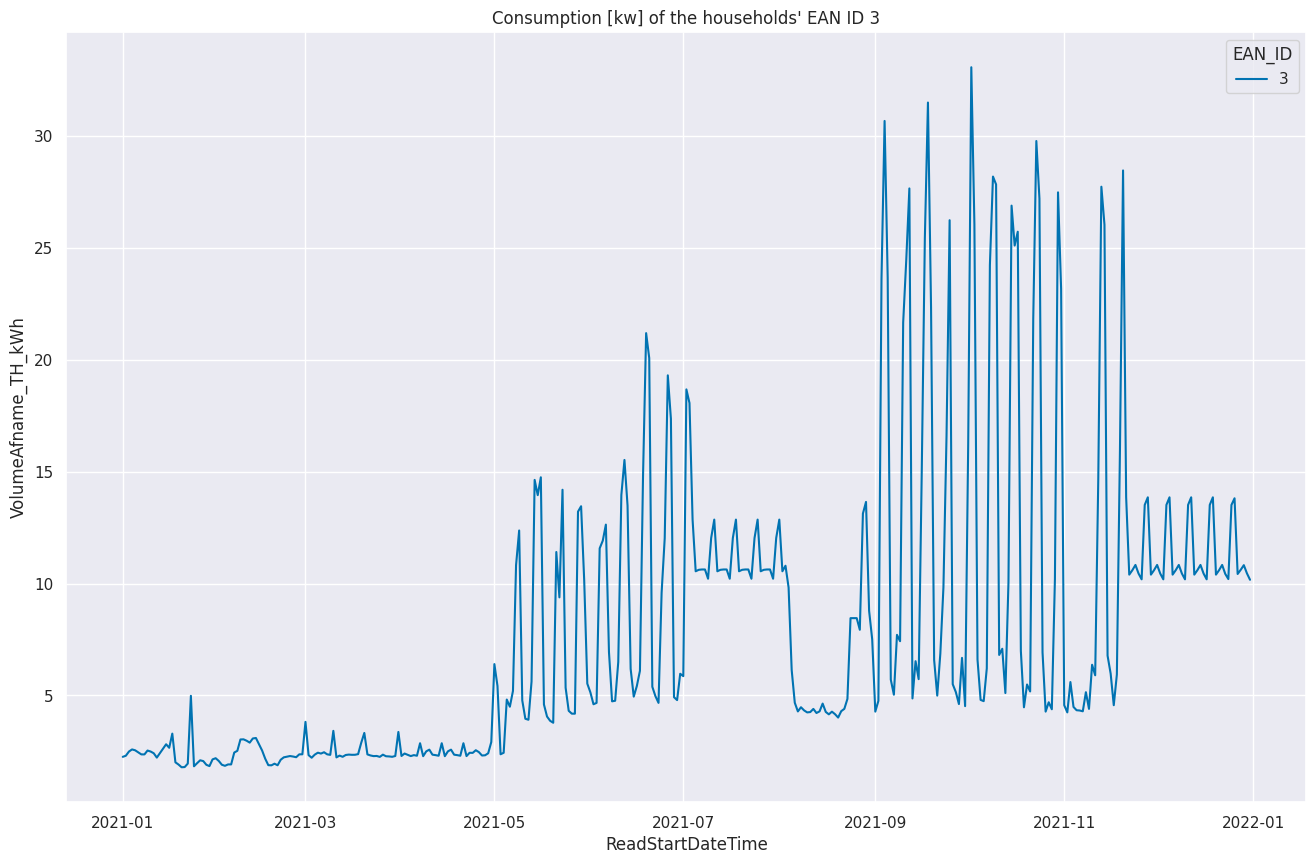

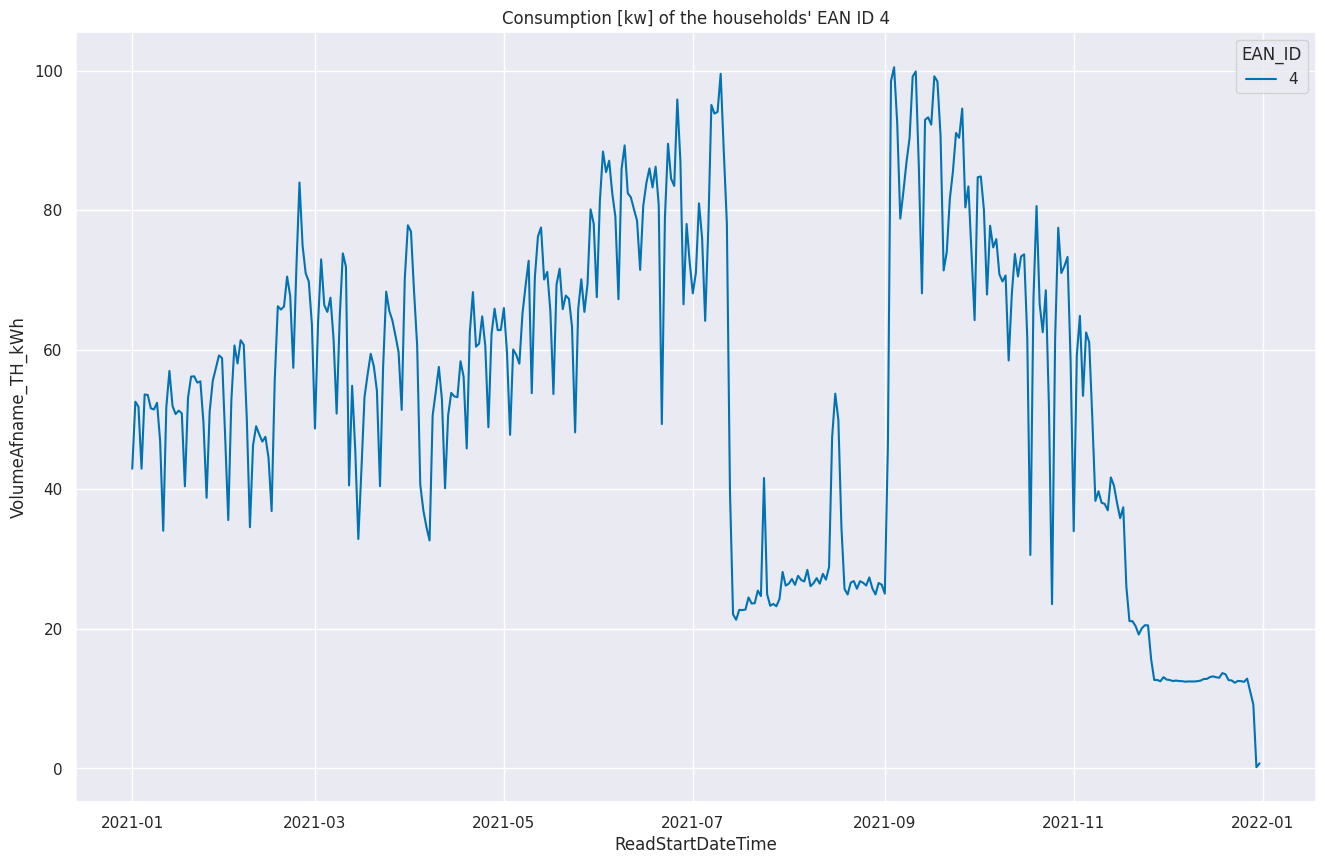

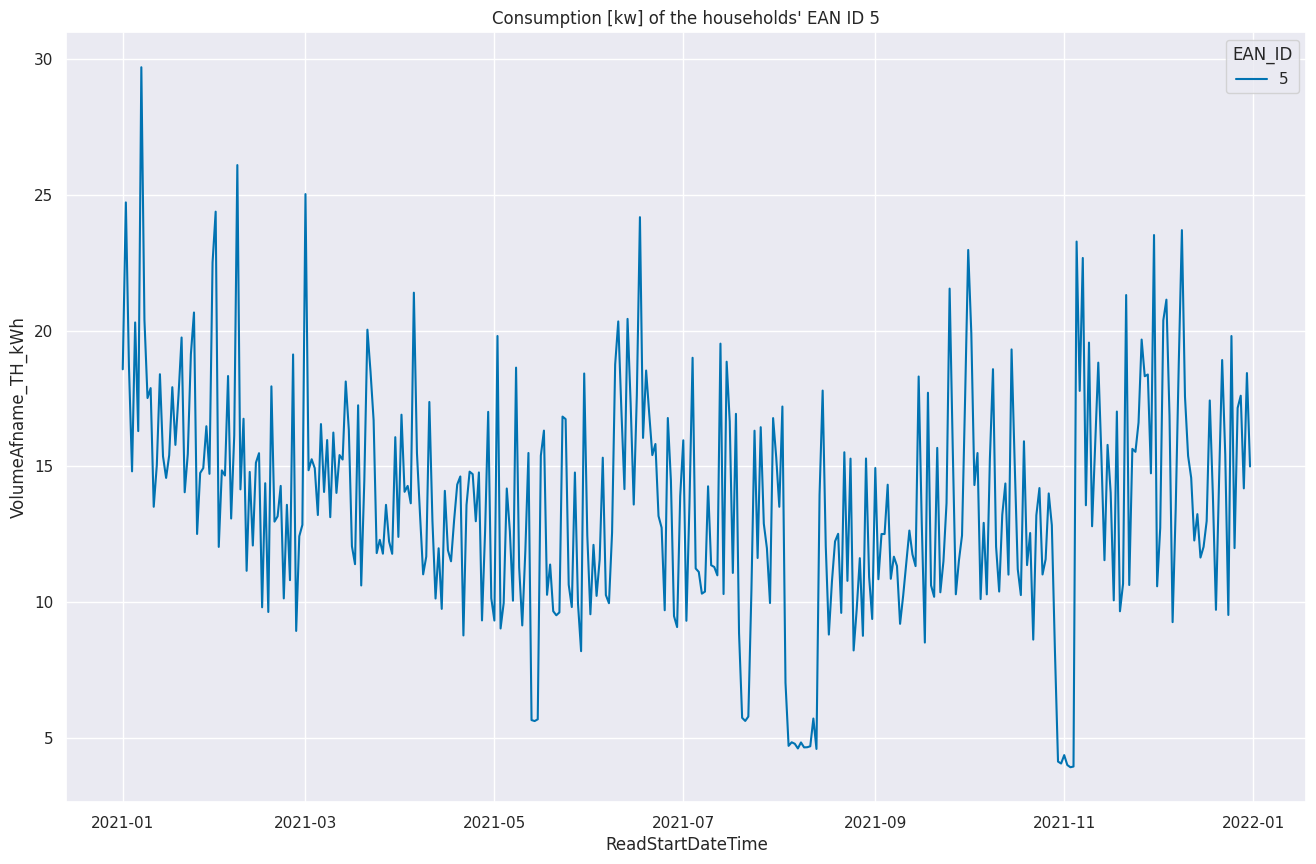

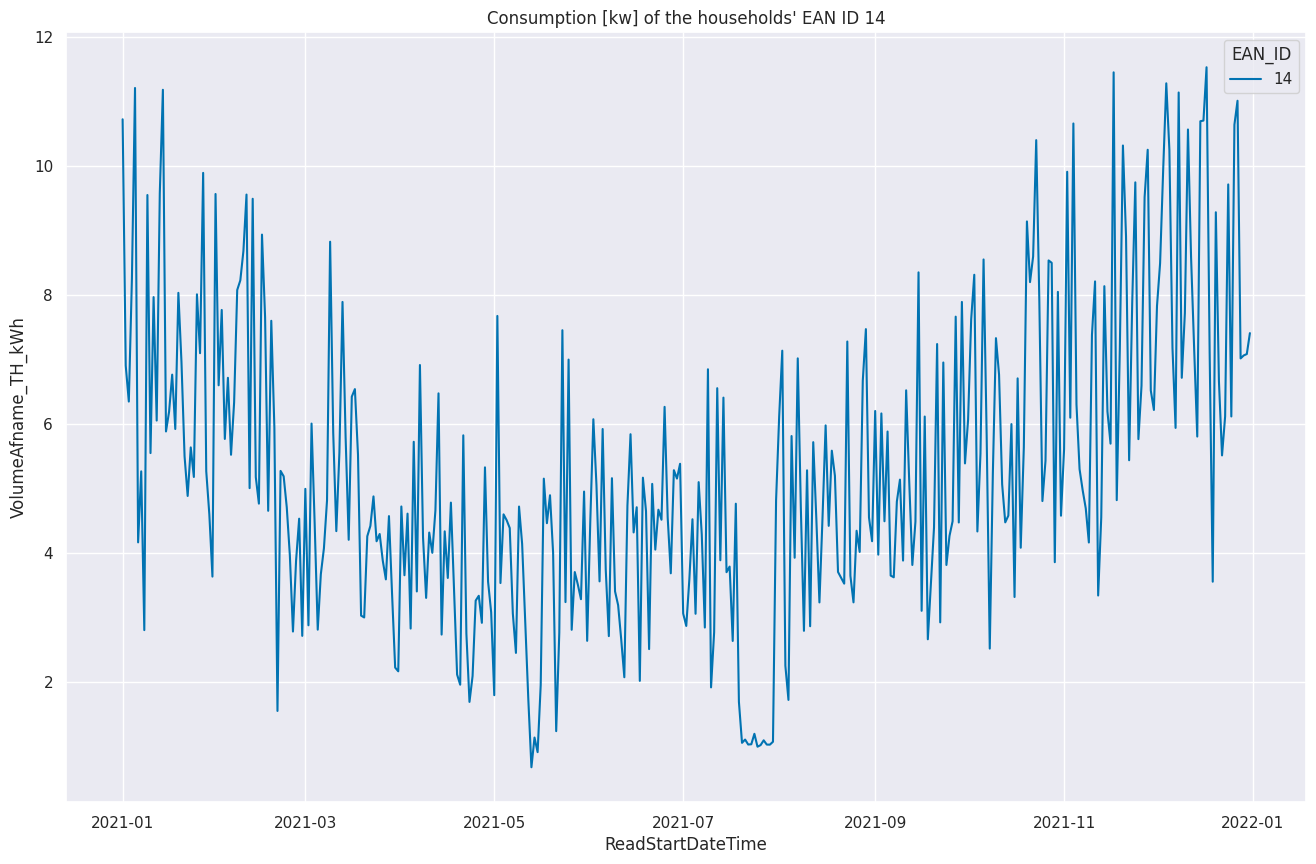

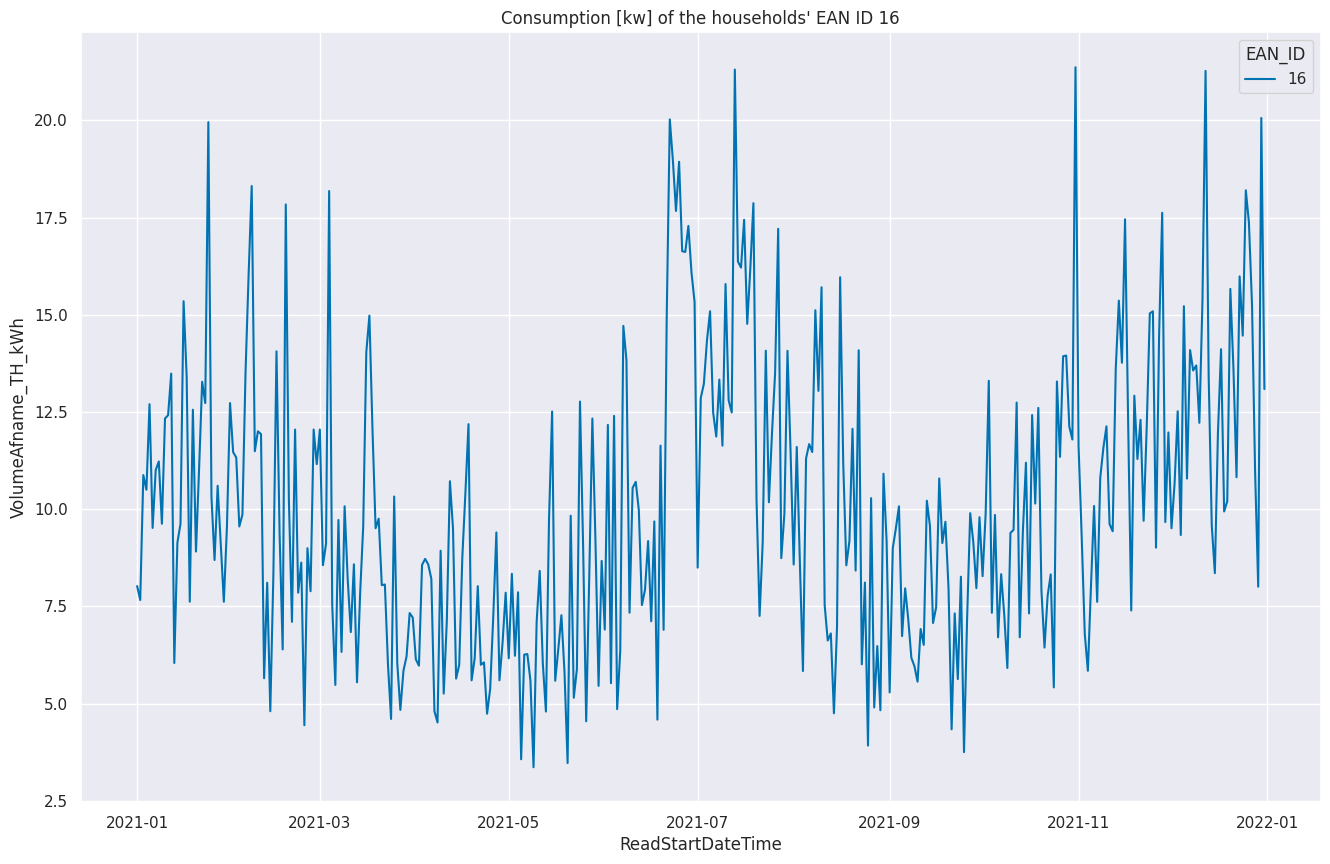

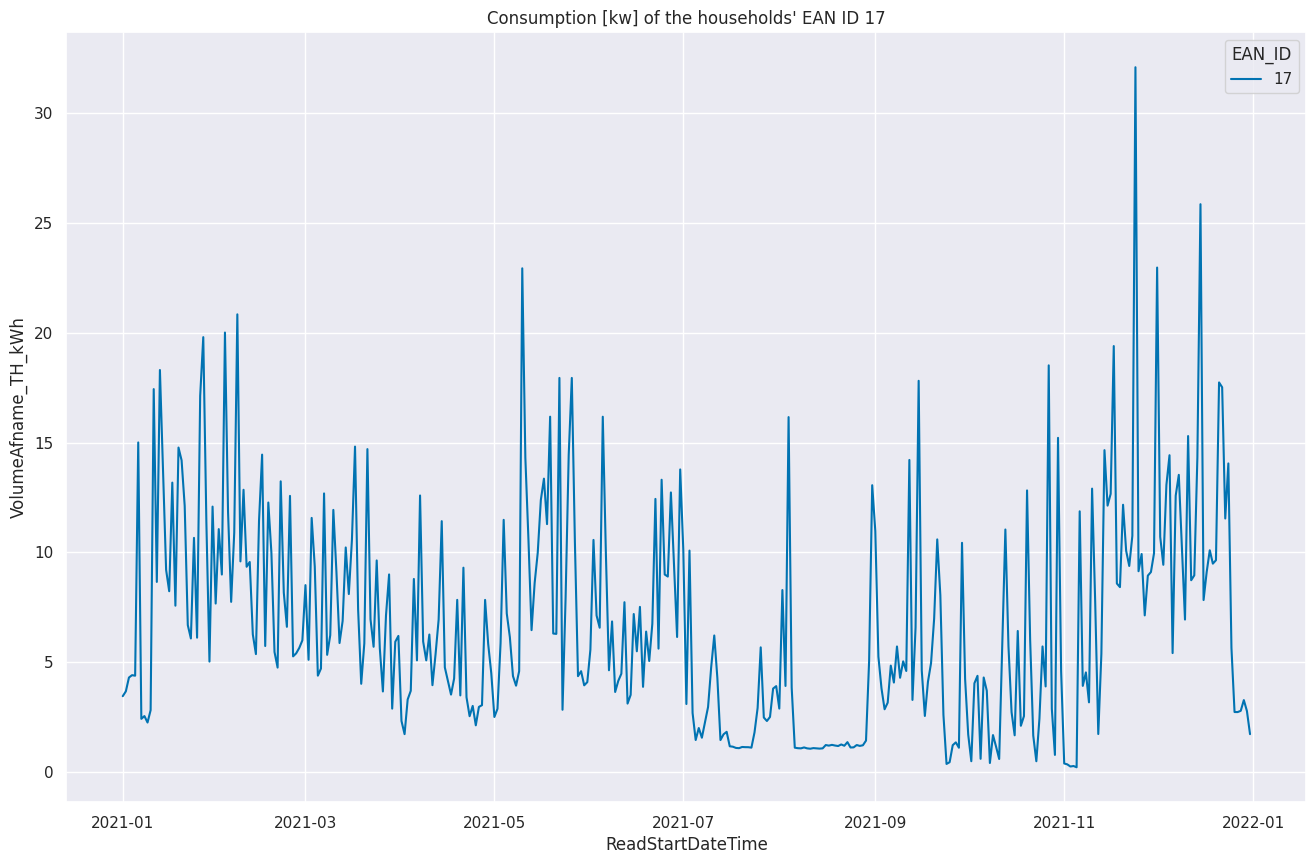

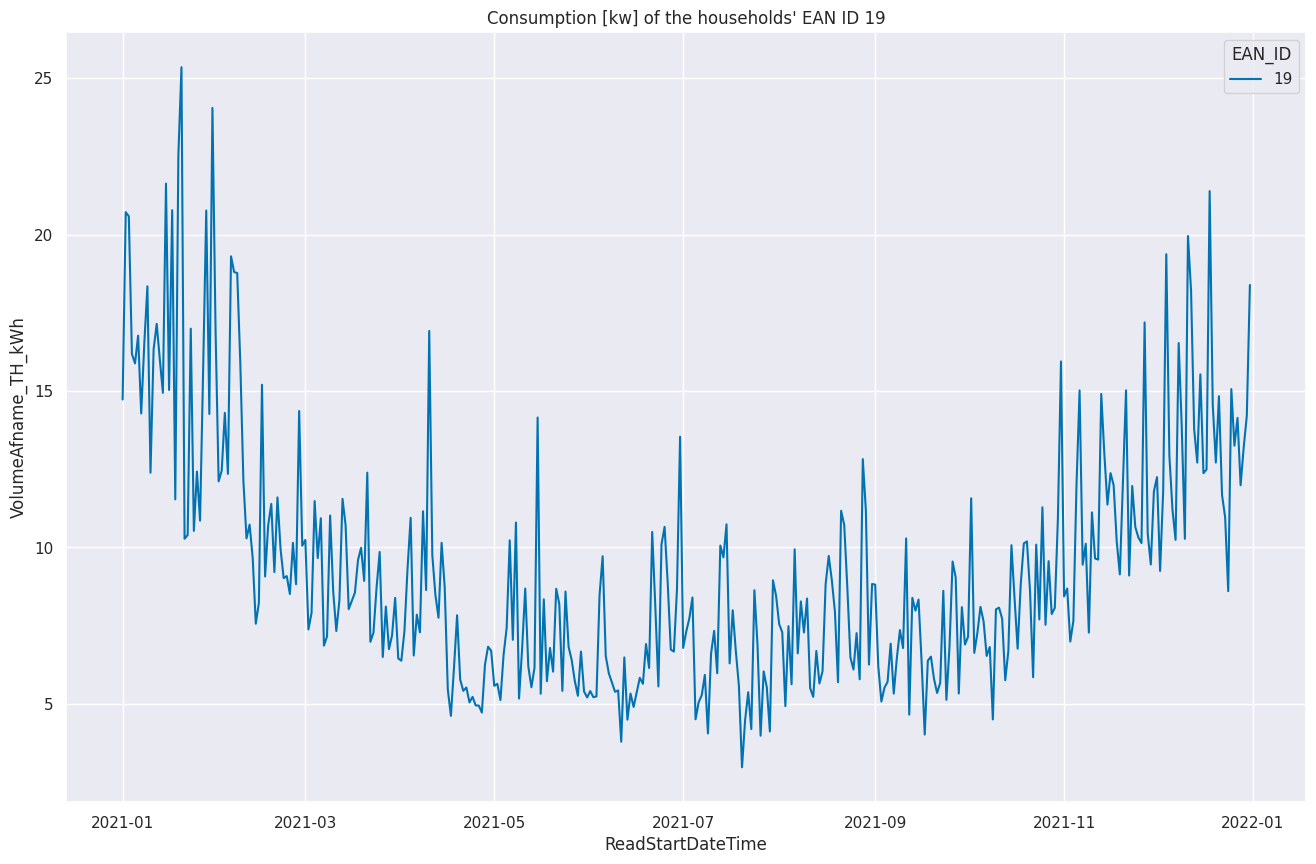

In [55]:
"""Consumption"""
categories = data_EAN['EAN_ID'].unique() # To get each EAN
for category in categories:
    plt.figure(figsize=(16, 10))
    sns.set_theme(style="darkgrid")
    sns.lineplot(x="ReadStartDateTime",
                 y="VolumeAfname_TH_kWh",
                 hue="EAN_ID",
                 palette='colorblind',
                 data=data_resample_d[data_resample_d['EAN_ID'] == category])
    plt.title(f"Consumption [kw] of the households' EAN ID {category}")

#### Production

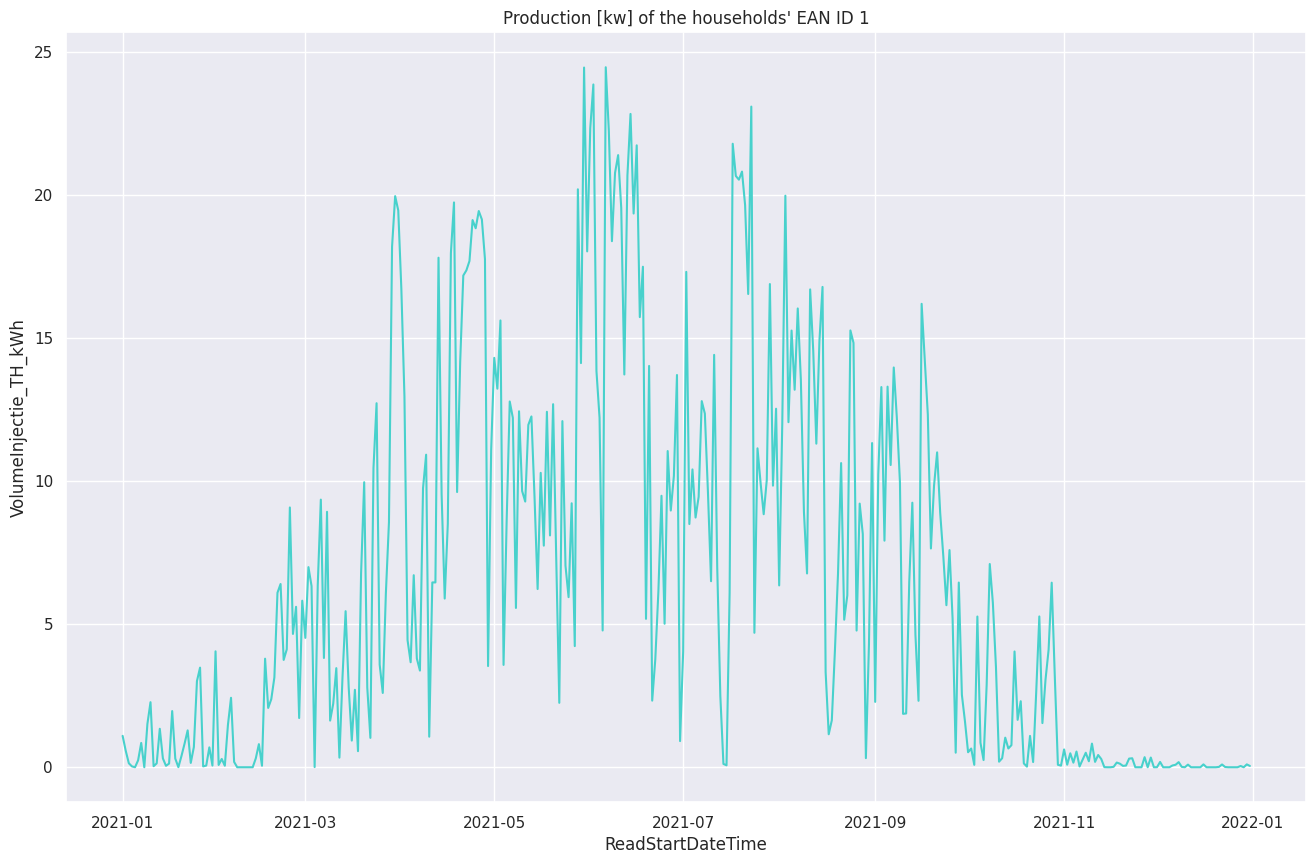

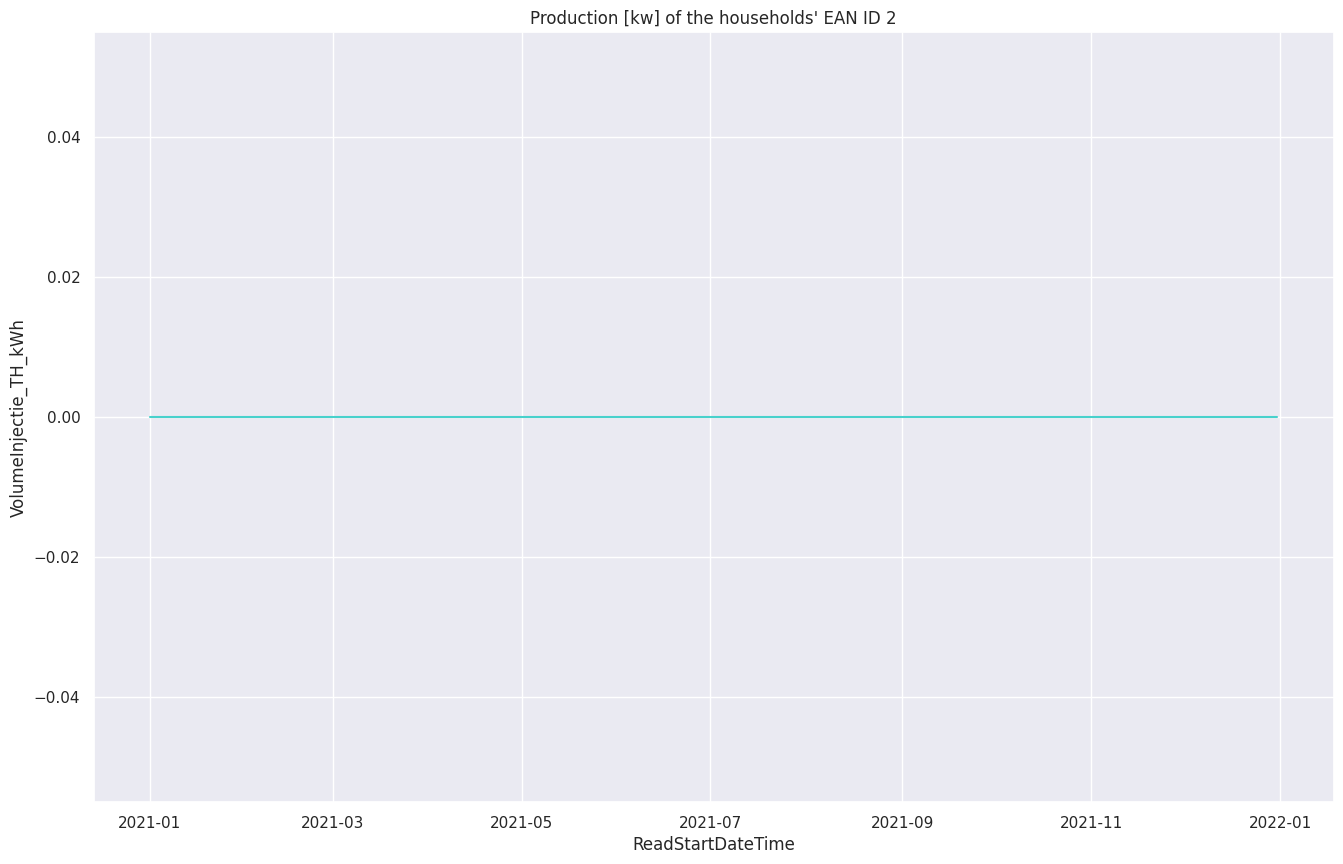

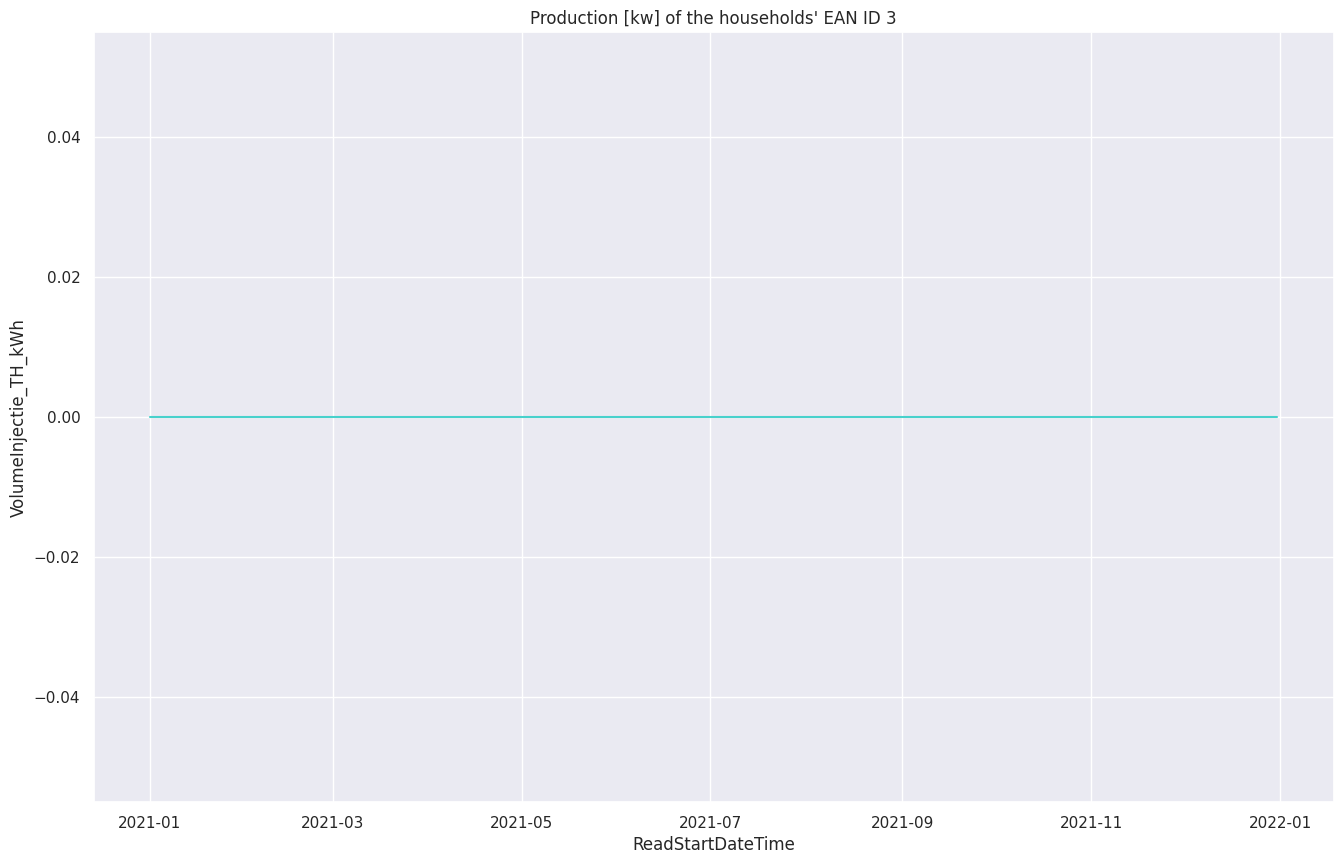

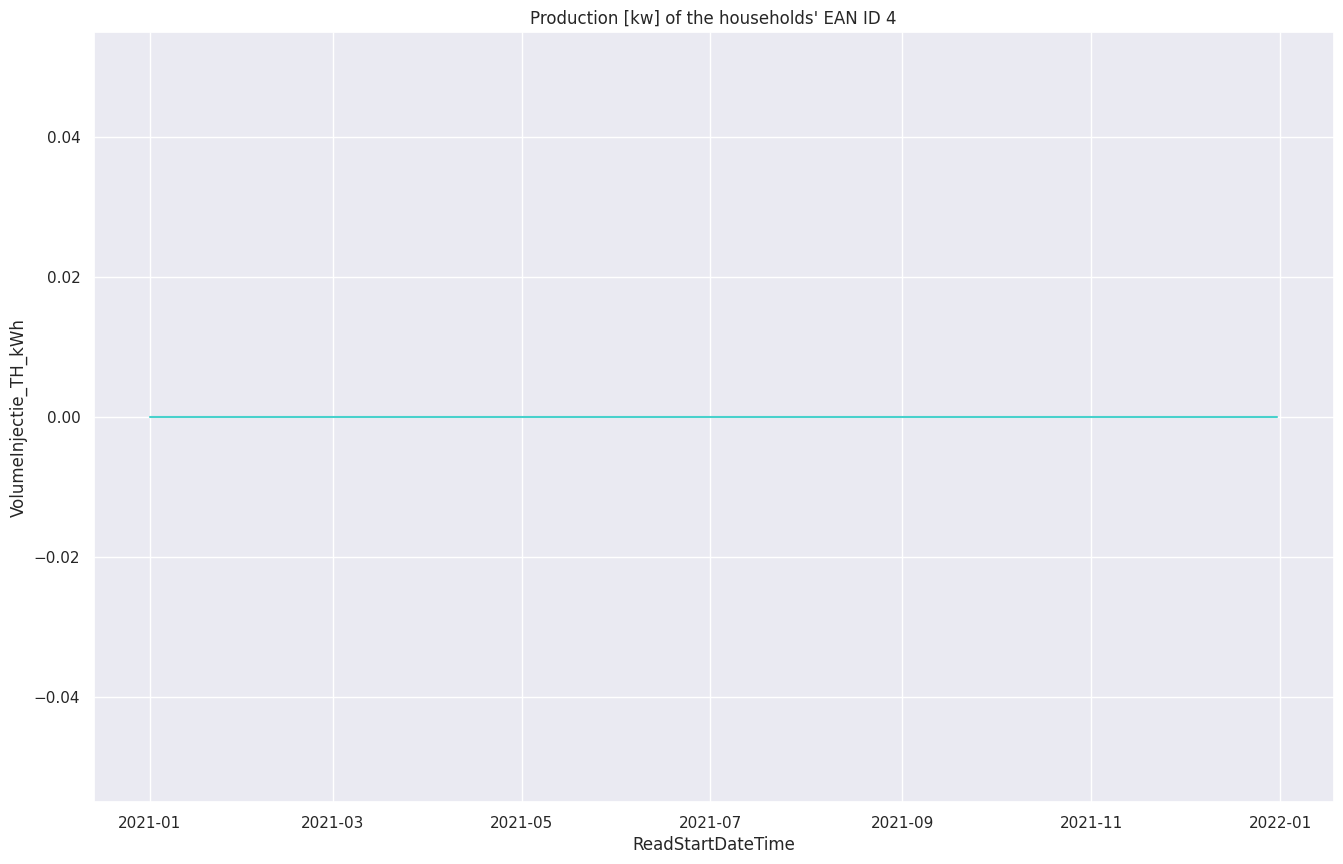

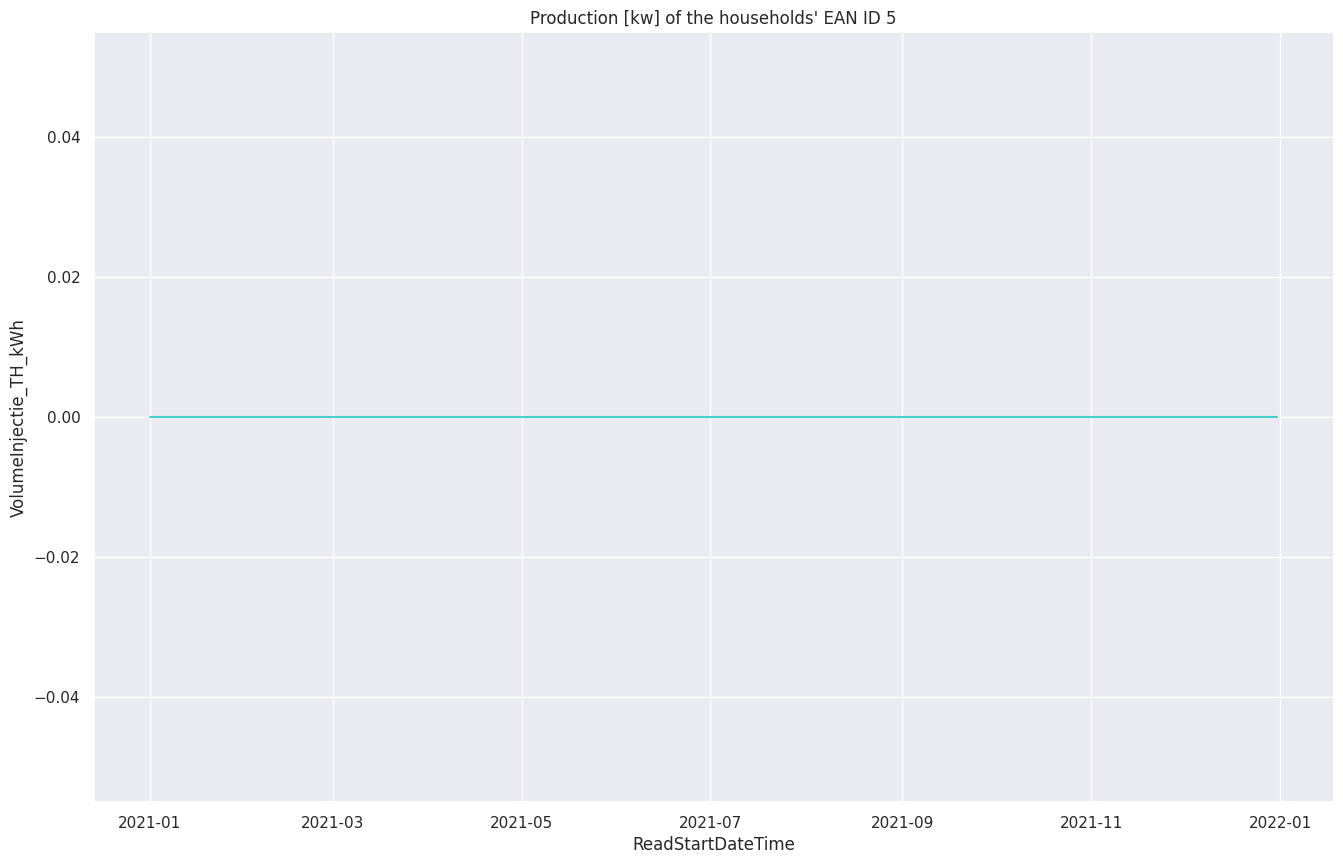

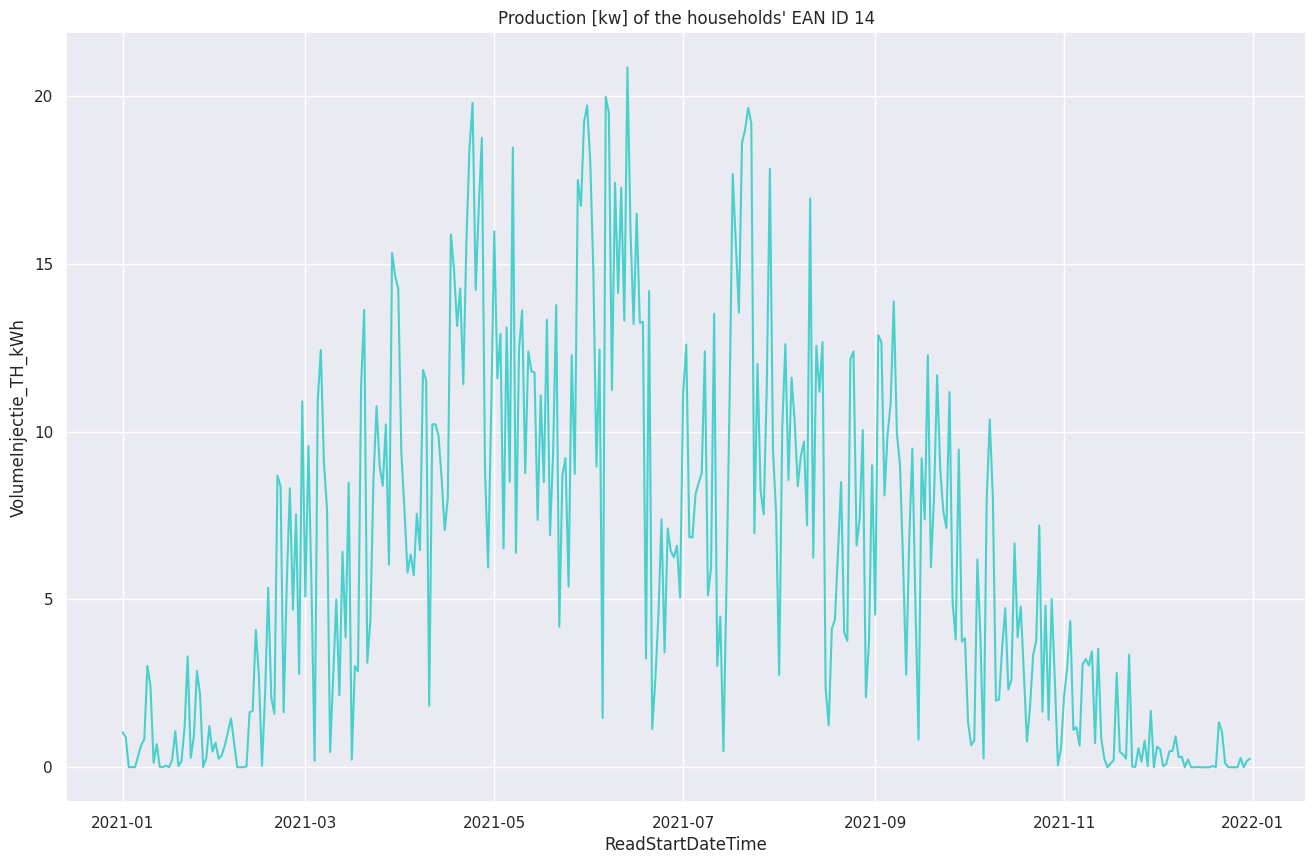

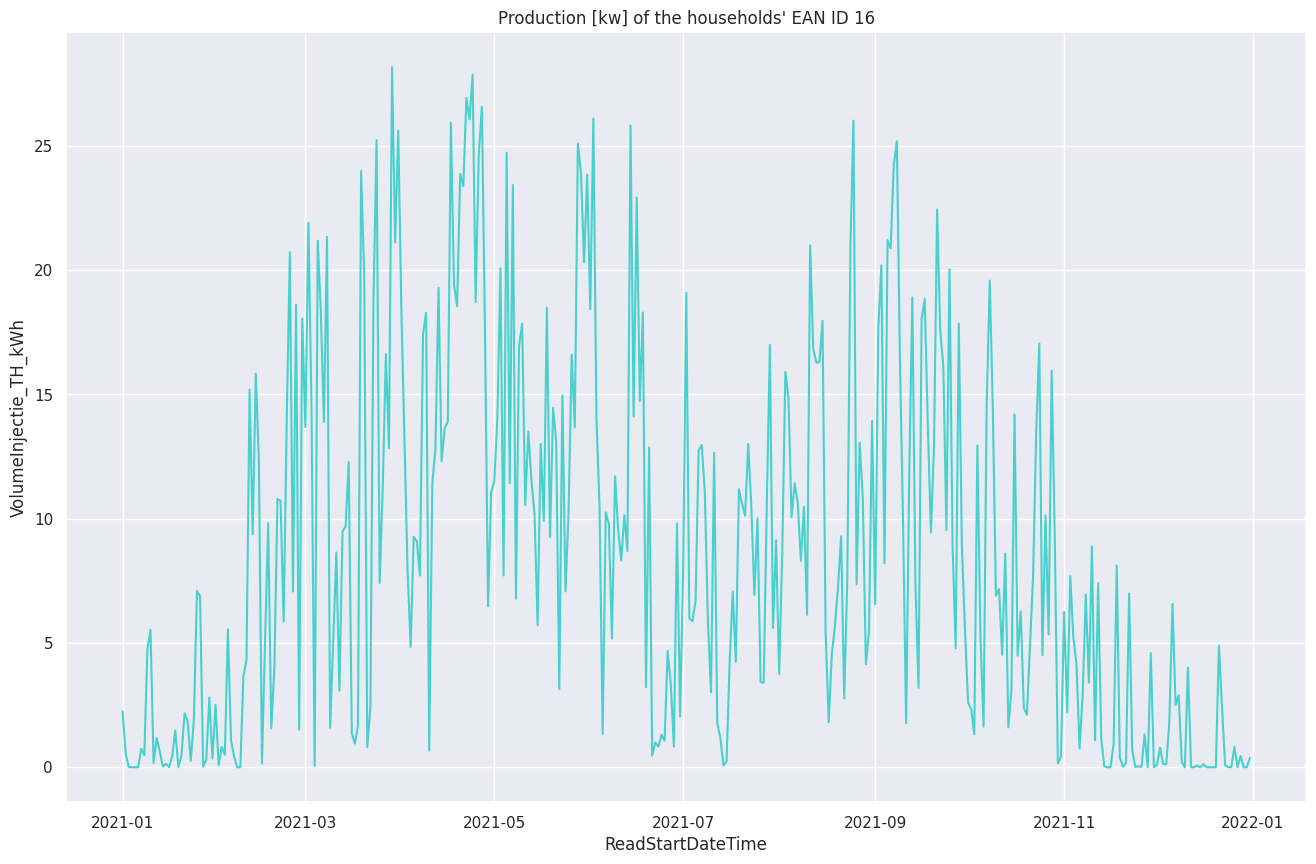

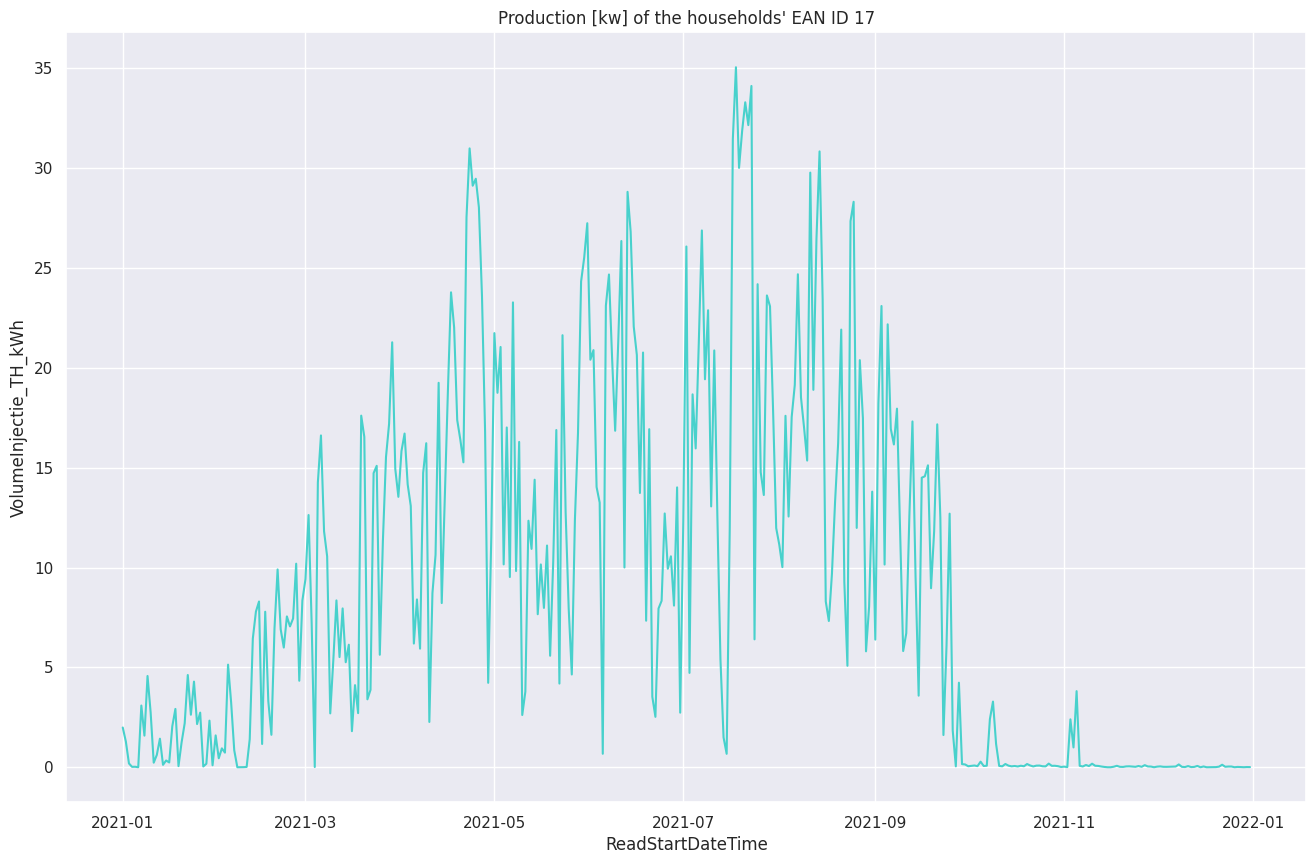

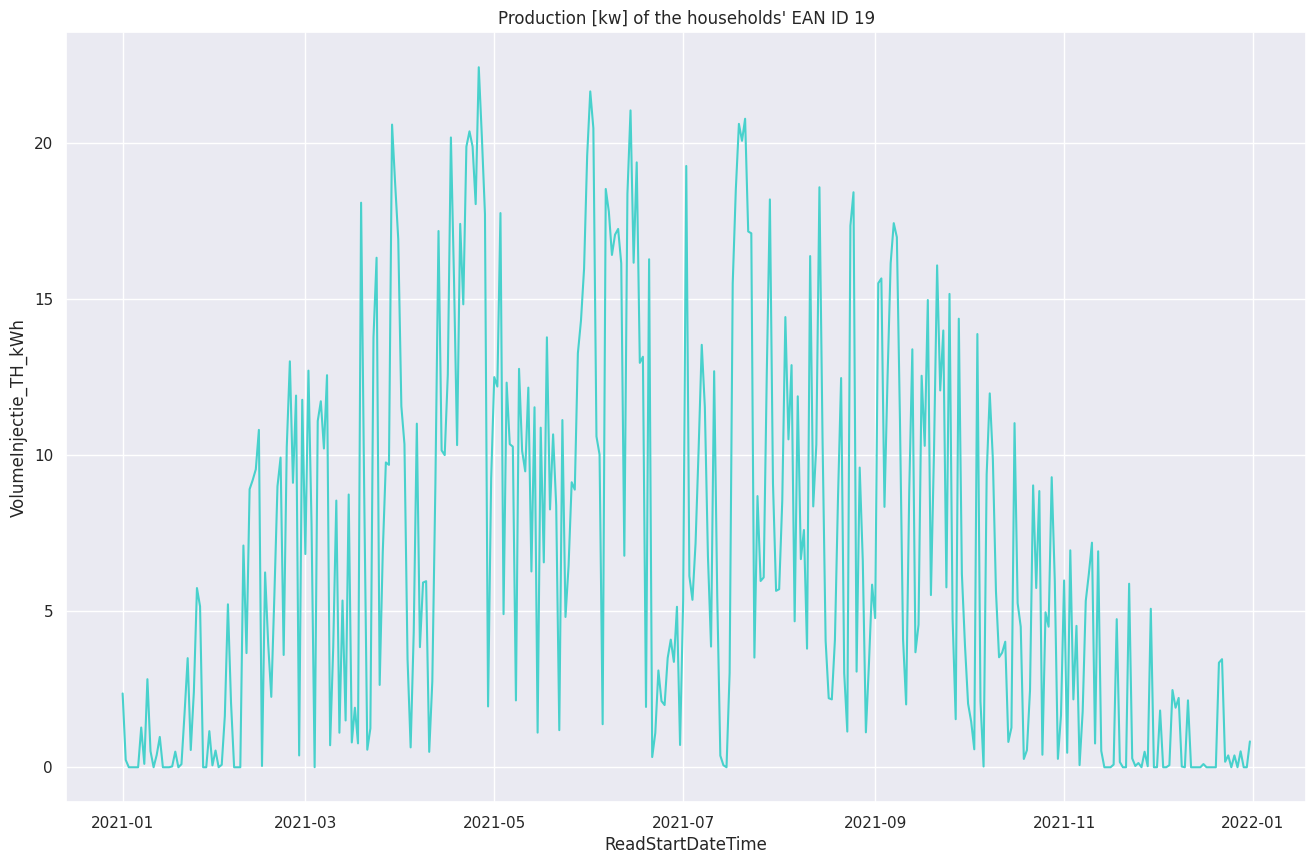

In [328]:
"""Production"""
categories = data_EAN['EAN_ID'].unique()
for category in categories:
    plt.figure(figsize=(16, 10))
    sns.set_theme(style="darkgrid")
    sns.lineplot(x="ReadStartDateTime",
                 y="VolumeInjectie_TH_kWh",
                 color='mediumturquoise',
                 data=data_resample_d[data_resample_d['EAN_ID'] == category])
    plt.title(f"Production [kw] of the households' EAN ID {category}")

### Let's now focus on one EAN (= 1) resampled by day

#### Create features

In [95]:
data_EAN_1 = data_resample_d.loc[data_resample_d['EAN_ID'] == 1]
data_EAN_1

EAN_ID ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh
0         1        2021-01-01               19.608                  1.097
1         1        2021-01-02               18.551                  0.576
2         1        2021-01-03               11.107                  0.140
3         1        2021-01-04               21.706                  0.031
4         1        2021-01-05               18.368                  0.000
..      ...               ...                  ...                    ...
360       1        2021-12-27               13.175                  0.000
361       1        2021-12-28               12.878                  0.044
362       1        2021-12-29               19.133                  0.000
363       1        2021-12-30               14.037                  0.100
364       1        2021-12-31               15.797                  0.046

[365 rows x 4 columns]

In [101]:
"""Doesn't make sense in here because aggregated by day, there is no more hours detailed in the column
ReadStartDateTime, then no more HI and LO Time Frame --> Hence the warnings"""
data_EAN_1_featured = features_creation(data_EAN_1)
data_EAN_1_featured

/tmp/ipykernel_1801/3807357452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_day'] = df['ReadStartDateTime'].dt.weekday
/tmp/ipykernel_1801/3807357452.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['week_day/wee_end_day'] = df['week_day'].apply(lambda x: 'week_end' if x > 5 else 'week_day')
/tmp/ipykernel_1801/3807357452.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

ReadStartDateTime  EAN_ID  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0          2021-01-01       1               19.608                  1.097   
1          2021-01-02       1               18.551                  0.576   
2          2021-01-03       1               11.107                  0.140   
3          2021-01-04       1               21.706                  0.031   
4          2021-01-05       1               18.368                  0.000   
..                ...     ...                  ...                    ...   
360        2021-12-27       1               13.175                  0.000   
361        2021-12-28       1               12.878                  0.044   
362        2021-12-29       1               19.133                  0.000   
363        2021-12-30       1               14.037                  0.100   
364        2021-12-31       1               15.797                  0.046   

     week_day week_day/wee_end_day  hour  day  month  quarter  year  
0           4             week_day     0    1      1        1  2021  
1           5             week_day     0    2      1        1  2021  
2           6             week_end     0    3      1        1  2021  
3           0             week_day     0    4      1        1  2021  
4           1             week_day     0    5      1        1  2021  
..        ...                  ...   ...  ...    ...      ...   ...  
360         0             week_day     0   27     12        4  2021  
361         1             week_day     0   28     12        4  2021  
362         2             week_day     0   29     12        4  2021  
363         3             week_day     0   30     12        4  2021  
364         4             week_day     0   31     12        4  2021  

[365 rows x 11 columns]

#### Consumtpion

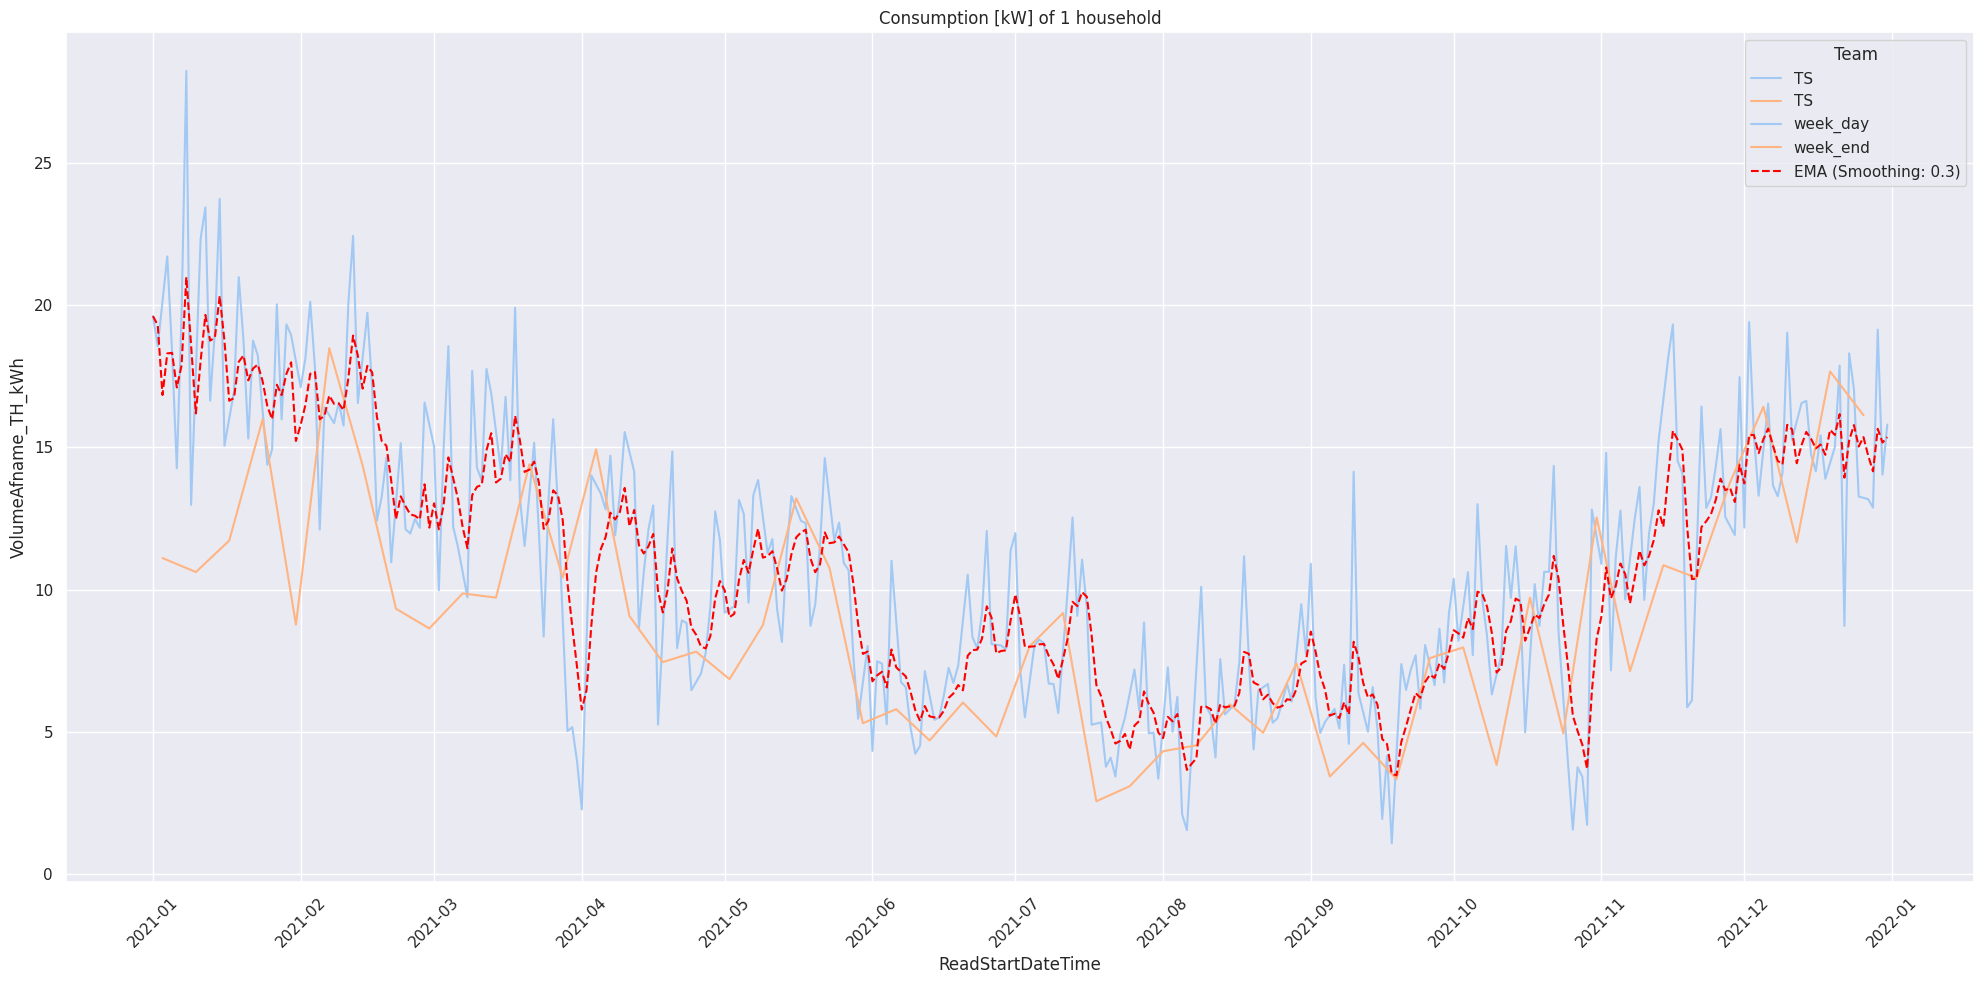

In [59]:
# Create a figure and a single set of axes
plt.figure(figsize=(20, 10))
ax = plt.gca()  # Get the current axes
sns.set_theme(style="darkgrid")

# Calculate the exponential moving average (EMA) for the entire time range
# EMA is a type of moving average that gives more weight to recent data points
alpha = 0.3 # Smoothing factor : larger values of alpha will result in less smoothing and more responsiveness to recent data points.
ema = data_EAN_1['VolumeAfname_TH_kWh'].ewm(alpha=alpha, adjust=False).mean()

#Plot Time-Series
sns.lineplot(x="ReadStartDateTime",
             y="VolumeAfname_TH_kWh",
             palette='pastel',
             hue='week_day/wee_end_day',
             data=data_EAN_1,
             label='TS')
#Plot TS smoothed
plt.plot(data_EAN_1.ReadStartDateTime, ema.values, color='red', 
         linestyle='dashed', label=f'EMA (Smoothing: {alpha})')

#place of the legend-
plt.legend(loc='upper right', title='Team')
plt.title('Consumption [kW] of 1 household')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Show the first day of each month and (control total number of dates)
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=1))
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

# Show the plot
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

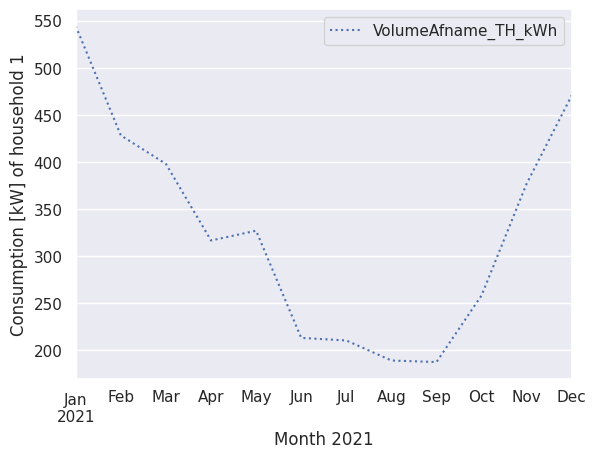

In [60]:
data_EAN_1_select = data_EAN[data_EAN['EAN_ID']==1]
'''Must set Dates as index before ressampling'''
data_EAN_1_select.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
frequence_sampled = data_EAN_1_select.resample('M').sum()
frequence_sampled.plot(y='VolumeAfname_TH_kWh',
            style=[':', '--', '-'])
plt.ylabel('Consumption [kW] of household 1');
plt.xlabel('Month 2021');

# plt.legend(loc='upper right', title='Team')
# plt.title('Consumption [kW] of household 1')
# Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

In [107]:
data_EAN_1_featured

ReadStartDateTime  EAN_ID  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0          2021-01-01       1               19.608                  1.097   
1          2021-01-02       1               18.551                  0.576   
2          2021-01-03       1               11.107                  0.140   
3          2021-01-04       1               21.706                  0.031   
4          2021-01-05       1               18.368                  0.000   
..                ...     ...                  ...                    ...   
360        2021-12-27       1               13.175                  0.000   
361        2021-12-28       1               12.878                  0.044   
362        2021-12-29       1               19.133                  0.000   
363        2021-12-30       1               14.037                  0.100   
364        2021-12-31       1               15.797                  0.046   

     week_day week_day/wee_end_day  hour  day  month  quarter  year  
0           4             week_day     0    1      1        1  2021  
1           5             week_day     0    2      1        1  2021  
2           6             week_end     0    3      1        1  2021  
3           0             week_day     0    4      1        1  2021  
4           1             week_day     0    5      1        1  2021  
..        ...                  ...   ...  ...    ...      ...   ...  
360         0             week_day     0   27     12        4  2021  
361         1             week_day     0   28     12        4  2021  
362         2             week_day     0   29     12        4  2021  
363         3             week_day     0   30     12        4  2021  
364         4             week_day     0   31     12        4  2021  

[365 rows x 11 columns]

In [106]:
"""Set/Reset dates as index before"""
# data_EAN_1.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_EAN_1.reset_index(inplace=True) # Comment/uncomment this row or the previous one
specific_day = data_EAN_1_featured[data_EAN_1_featured[ReadStartDateTime =='2021-01-04']]


sns.set(style='whitegrid')  # Optional: Set a Seaborn style

plt.figure(figsize=(12, 6))  # Optional: Set the figure size

sns.lineplot(x=specific_day.index, y=data_EAN_1_featured['VolumeAfname_TH_kWh'], label='Your Data')

plt.title('Time Series Data for an Entire Day')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)

plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

NameError: name 'ReadStartDateTime' is not defined

#### Production

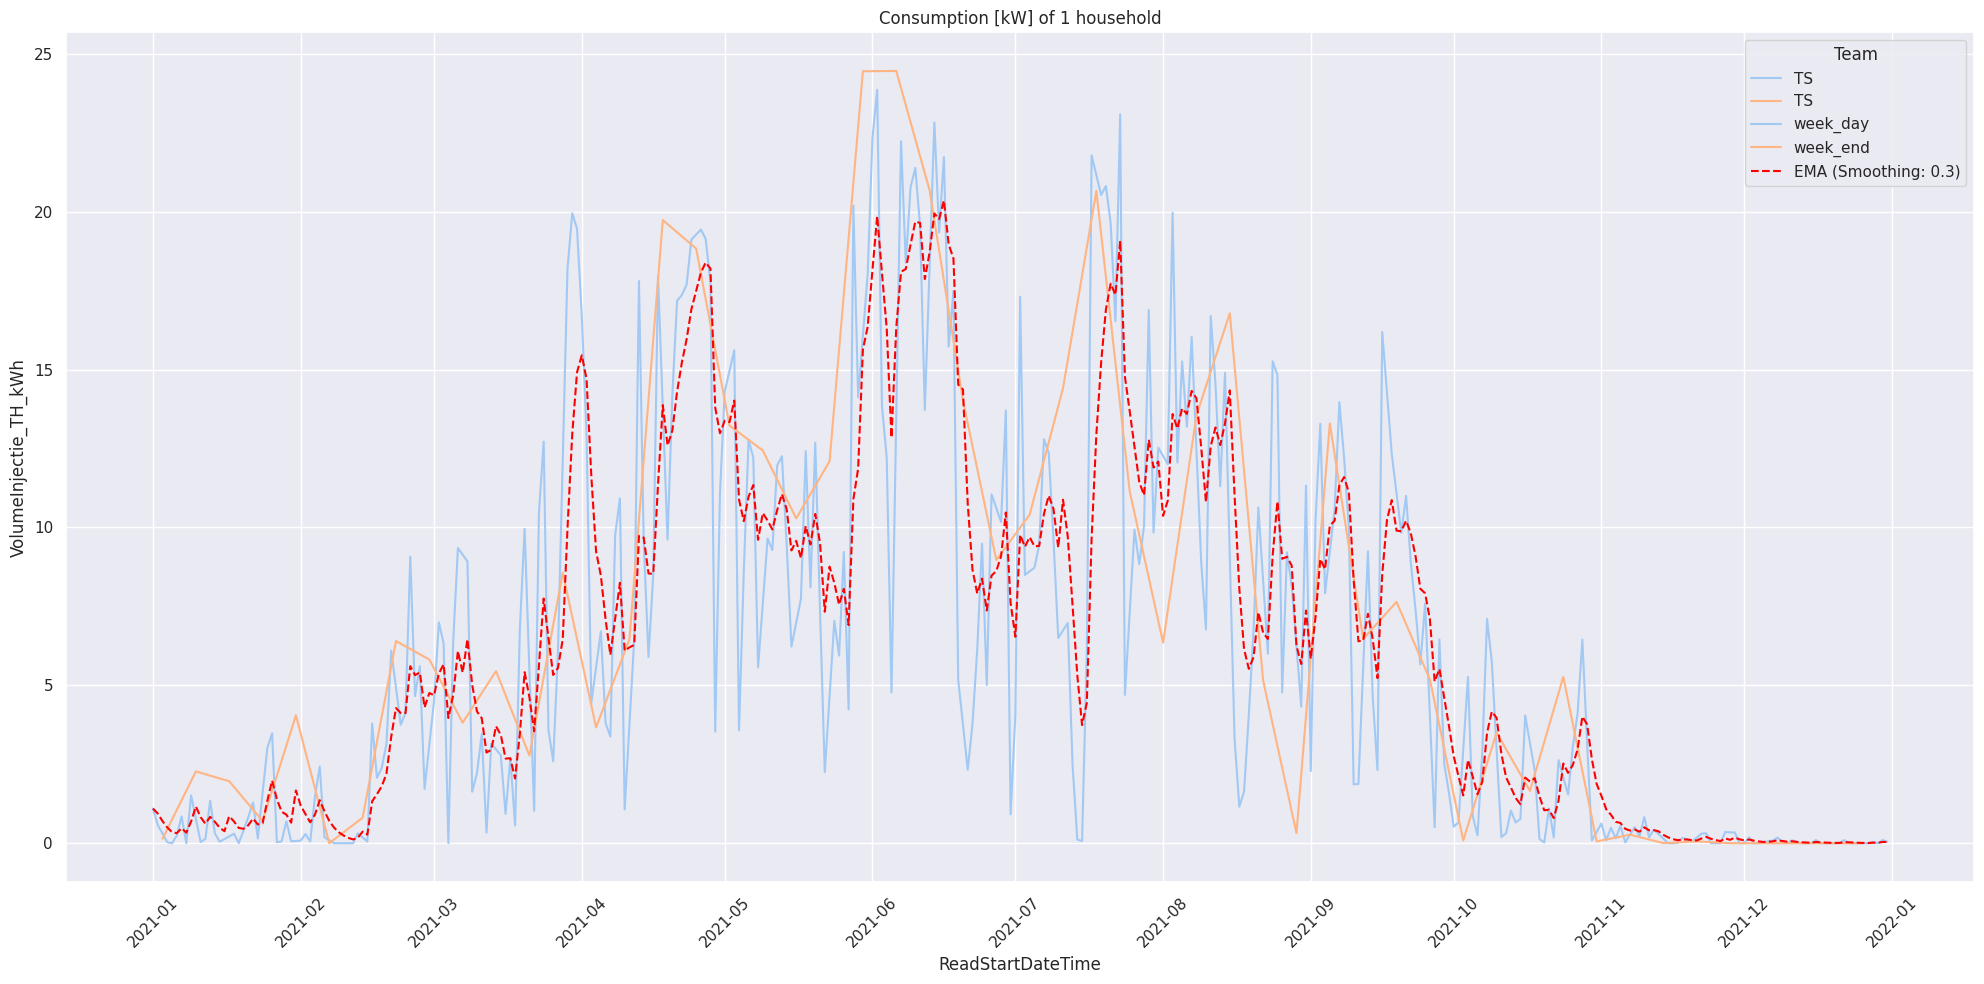

In [344]:
# Create a figure and a single set of axes
plt.figure(figsize=(20, 10))
ax = plt.gca()  # Get the current axes
sns.set_theme(style="darkgrid")

# Calculate the exponential moving average (EMA) for the entire time range
# EMA is a type of moving average that gives more weight to recent data points
alpha = 0.3 # Smoothing factor : larger values of alpha will result in less smoothing and more responsiveness to recent data points.
ema = data_EAN_1['VolumeInjectie_TH_kWh'].ewm(alpha=alpha, adjust=False).mean()

#Plot Time-Series
sns.lineplot(x="ReadStartDateTime",
             y="VolumeInjectie_TH_kWh",
             palette='pastel',
             hue='week_day/wee_end_day',
             data=data_EAN_1,
             label='TS')
#Plot TS smoothed
plt.plot(data_EAN_1.ReadStartDateTime, ema.values, color='red', linestyle='dashed', label=f'EMA (Smoothing: {alpha})')

#place of the legend-
plt.legend(loc='upper right', title='Team')
plt.title('Consumption [kW] of 1 household')
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
# Show the first day of each month and (control total number of dates)
plt.gca().xaxis.set_major_locator(MonthLocator(bymonthday=1))
# plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) 

# Show the plot
plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

# 🧠Forecasting

## Consumption

In [34]:
"""MANQUE LES EANS"""
''' Train_test_split'''
df_train_reconstructed = []
df_test_reconstructed = []

categories = data_EAN['EAN_ID'].unique()
for category in categories:
    subset_data = data_EAN[data_EAN['EAN_ID'] == category]['VolumeAfname_TH_kWh']
    # Let's keep the last 40% of the values out for testing purposes
    train_size = 0.6
    index = round(train_size*subset_data.shape[0])
    df_train = subset_data.iloc[:index]
    df_test = subset_data.iloc[index:]
    
    df_train_reconstructed.append(df_train)
    df_test_reconstructed.append(df_test)
final_df_train = pd.concat(df_train_reconstructed, ignore_index=True)
final_df_test = pd.concat(df_test_reconstructed, ignore_index=True)

In [35]:
display(final_df_train)
display(final_df_test)

0         0.076
1         0.048
2         0.038
3         0.317
4         0.570
          ...  
189211    0.074
189212    0.060
189213    0.067
189214    0.169
189215    0.078
Name: VolumeAfname_TH_kWh, Length: 189216, dtype: float64

0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
          ...  
126139    0.360
126140    0.475
126141    0.168
126142    0.407
126143    0.148
Name: VolumeAfname_TH_kWh, Length: 126144, dtype: float64

## TEST sur 1 EAN

In [36]:
subset_data = data_EAN[data_EAN['EAN_ID'] == 1]['VolumeAfname_TH_kWh']
# Let's keep the last 40% of the values out for testing purposes
train_size = 0.6
index = round(train_size*subset_data.shape[0])
train = subset_data.iloc[:index]
test = subset_data.iloc[index:]

In [37]:
display(df_train,df_test)

280320    0.258
280321    0.185
280322    0.393
280323    0.322
280324    0.430
          ...  
301339    0.074
301340    0.060
301341    0.067
301342    0.169
301343    0.078
Name: VolumeAfname_TH_kWh, Length: 21024, dtype: float64

301344    0.129
301345    0.102
301346    0.060
301347    0.038
301348    0.039
          ...  
315355    0.360
315356    0.475
315357    0.168
315358    0.407
315359    0.148
Name: VolumeAfname_TH_kWh, Length: 14016, dtype: float64

In [ ]:
# Build model
arima = ARIMA(train, order=(0, 1, 3), trend='t')  
arima = arima.fit()

## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

In [ ]:
print(arima.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
# Actual vs Fitted
arima.plot_predict(dynamic=False)
plt.show()

In [ ]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

In [ ]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

In [ ]:
# Time series plot
"""Pas correct"""
categories = data_EAN['EAN_ID'].unique()
for category in categories:
    fig, ax = plt.subplots(figsize=(8, 3.5))
    df_train.VolumeAfname_TH_kWh.plot(x='ReadStartDate',ax=ax, label='train', linewidth=1)
    df_test.VolumeAfname_TH_kWh.plot(x='ReadStartDate',ax=ax, label='validation', linewidth=1)
    # data_test.Demand.plot(ax=ax, label='test', linewidth=1)
    ax.set_title('Electricity consumption')
    ax.legend();

In [ ]:
for category in categories:
    plt.figure(figsize=(16, 10))
    sns.set_theme(style="darkgrid")
    sns.lineplot(x="ReadStartDateTime",
                 y="VolumeAfname_TH_kWh",
                 
                 hue="EAN_ID",
                 palette='colorblind',
                 data=data_resample[data_resample['EAN_ID'] == category])
    plt.title(f"Consumption [kw] of the households' EAN ID {category}")

In [ ]:
"""Correct, faut maintenant spliter en train_test"""
unique_eans = data_EAN['EAN_ID'].unique()
# Loop through each unique EAN and create a pair of plots
for ean in unique_eans:
    ean_data = data_EAN[data_EAN['EAN_ID'] == ean]
    # Create a figure with two subplots (columns)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    # Loop through each subplot (column) and create a plot for the respective EAN
    for i, column in enumerate(['VolumeAfname_TH_kWh', 'VolumeInjectie_TH_kWh']):      
        ax = axes[i]  # Select the current axis
        # Create a line plot using Seaborn
        sns.set_theme(style="darkgrid")
        sns.lineplot(x="ReadStartDateTime",
                     y=column,
                     palette='colorblind',
                     ax=ax,
                     data=ean_data)
        ax.set_title(f"{column} [kw] of the household of EAN ID {ean}")
        ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(data_EAN['VolumeAfname_TH_kWh'],
                                model='additive')
result_add.plot()

## LSTM - Consumption 

### Create features

In [39]:
data_EAN

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1 2021-01-01 00:00:00                0.076   
1            1 2021-01-01 00:15:00                0.048   
2            1 2021-01-01 00:30:00                0.038   
3            1 2021-01-01 00:45:00                0.317   
4            1 2021-01-01 01:00:00                0.570   
...        ...                 ...                  ...   
315355      19 2021-12-31 22:45:00                0.360   
315356      19 2021-12-31 23:00:00                0.475   
315357      19 2021-12-31 23:15:00                0.168   
315358      19 2021-12-31 23:30:00                0.407   
315359      19 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  week_day week_day/wee_end_day  hour  day  \
0                         0.0         4             week_day     0    1   
1                         0.0         4             week_day     0    1   
2                         0.0         4             week_day     0    1   
3                         0.0         4             week_day     0    1   
4                         0.0         4             week_day     1    1   
...                       ...       ...                  ...   ...  ...   
315355                    0.0         4             week_day    22   31   
315356                    0.0         4             week_day    23   31   
315357                    0.0         4             week_day    23   31   
315358                    0.0         4             week_day    23   31   
315359                    0.0         4             week_day    23   31   

        month  quarter  year Time_Frame  
0           1        1  2021         LO  
1           1        1  2021         LO  
2           1        1  2021         LO  
3           1        1  2021         LO  
4           1        1  2021         LO  
...       ...      ...   ...        ...  
315355     12        4  2021         LO  
315356     12        4  2021         LO  
315357     12        4  2021         LO  
315358     12        4  2021         LO  
315359     12        4  2021         LO  

[315360 rows x 12 columns]

In [32]:
# display(data_resample_h[data_resample_h['EAN_ID'] == 1].shape)
# display(data_resample_h[data_resample_h['EAN_ID'] == 1].info())

### Frame the DF to predtict 'VolumeAfname_TH_kWh' FOR EAN 1

In [33]:
"""Set/Reset dates as index before resampling"""
data_EAN.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_EAN.reset_index(inplace=True) # Comment/uncomment this row or the previous one
data_EAN

EAN_ID ReadStartDate  VolumeAfname_TH_kWh  \
ReadStartDateTime                                                
2021-01-01 00:00:00       1    2021-01-01                0.076   
2021-01-01 00:15:00       1    2021-01-01                0.048   
2021-01-01 00:30:00       1    2021-01-01                0.038   
2021-01-01 00:45:00       1    2021-01-01                0.317   
2021-01-01 01:00:00       1    2021-01-01                0.570   
...                     ...           ...                  ...   
2021-12-31 22:45:00      19    2021-12-31                0.360   
2021-12-31 23:00:00      19    2021-12-31                0.475   
2021-12-31 23:15:00      19    2021-12-31                0.168   
2021-12-31 23:30:00      19    2021-12-31                0.407   
2021-12-31 23:45:00      19    2021-12-31                0.148   

                     VolumeInjectie_TH_kWh  weekday  hour  day  month  \
ReadStartDateTime                                                       
2021-01-01 00:00:00                    0.0        1     0    1      1   
2021-01-01 00:15:00                    0.0        1     0    1      1   
2021-01-01 00:30:00                    0.0        1     0    1      1   
2021-01-01 00:45:00                    0.0        1     0    1      1   
2021-01-01 01:00:00                    0.0        1     1    1      1   
...                                    ...      ...   ...  ...    ...   
2021-12-31 22:45:00                    0.0        1    22   31     12   
2021-12-31 23:00:00                    0.0        1    23   31     12   
2021-12-31 23:15:00                    0.0        1    23   31     12   
2021-12-31 23:30:00                    0.0        1    23   31     12   
2021-12-31 23:45:00                    0.0        1    23   31     12   

                     quarter  year Time_Frame  
ReadStartDateTime                              
2021-01-01 00:00:00        1  2021         LO  
2021-01-01 00:15:00        1  2021         LO  
2021-01-01 00:30:00        1  2021         LO  
2021-01-01 00:45:00        1  2021         LO  
2021-01-01 01:00:00        1  2021         LO  
...                      ...   ...        ...  
2021-12-31 22:45:00        4  2021         LO  
2021-12-31 23:00:00        4  2021         LO  
2021-12-31 23:15:00        4  2021         LO  
2021-12-31 23:30:00        4  2021         LO  
2021-12-31 23:45:00        4  2021         LO  

[315360 rows x 11 columns]

In [41]:
data_EAN_1 = data_EAN[data_EAN['EAN_ID'] == 1]
data_EAN_1

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0           1 2021-01-01 00:00:00                0.076                    0.0   
1           1 2021-01-01 00:15:00                0.048                    0.0   
2           1 2021-01-01 00:30:00                0.038                    0.0   
3           1 2021-01-01 00:45:00                0.317                    0.0   
4           1 2021-01-01 01:00:00                0.570                    0.0   
...       ...                 ...                  ...                    ...   
35035       1 2021-12-31 22:45:00                0.071                    0.0   
35036       1 2021-12-31 23:00:00                0.076                    0.0   
35037       1 2021-12-31 23:15:00                0.077                    0.0   
35038       1 2021-12-31 23:30:00                0.083                    0.0   
35039       1 2021-12-31 23:45:00                0.062                    0.0   

       week_day week_day/wee_end_day  hour  day  month  quarter  year  \
0             4             week_day     0    1      1        1  2021   
1             4             week_day     0    1      1        1  2021   
2             4             week_day     0    1      1        1  2021   
3             4             week_day     0    1      1        1  2021   
4             4             week_day     1    1      1        1  2021   
...         ...                  ...   ...  ...    ...      ...   ...   
35035         4             week_day    22   31     12        4  2021   
35036         4             week_day    23   31     12        4  2021   
35037         4             week_day    23   31     12        4  2021   
35038         4             week_day    23   31     12        4  2021   
35039         4             week_day    23   31     12        4  2021   

      Time_Frame  
0             LO  
1             LO  
2             LO  
3             LO  
4             LO  
...          ...  
35035         LO  
35036         LO  
35037         LO  
35038         LO  
35039         LO  

[35040 rows x 12 columns]

In [43]:
data_framed = data_EAN_1[['VolumeAfname_TH_kWh', 'week_day', 'hour', 'day', 
                       'month', 'quarter','year', 'Time_Frame']]
data_framed

VolumeAfname_TH_kWh  week_day  hour  day  month  quarter  year  \
0                    0.076         4     0    1      1        1  2021   
1                    0.048         4     0    1      1        1  2021   
2                    0.038         4     0    1      1        1  2021   
3                    0.317         4     0    1      1        1  2021   
4                    0.570         4     1    1      1        1  2021   
...                    ...       ...   ...  ...    ...      ...   ...   
35035                0.071         4    22   31     12        4  2021   
35036                0.076         4    23   31     12        4  2021   
35037                0.077         4    23   31     12        4  2021   
35038                0.083         4    23   31     12        4  2021   
35039                0.062         4    23   31     12        4  2021   

      Time_Frame  
0             LO  
1             LO  
2             LO  
3             LO  
4             LO  
...          ...  
35035         LO  
35036         LO  
35037         LO  
35038         LO  
35039         LO  

[35040 rows x 8 columns]

### Modelling

#### On all data

In [46]:
#Transform the VolumeAfname_TH_kWh column of the data DataFrame into a numpy array of float values
dataset = data_framed.VolumeAfname_TH_kWh.values.astype('float32')
display(dataset, dataset.shape)

#Reshape the numpy array into a 2D array with 1 column
dataset = np.reshape(dataset, (-1, 1))
display(dataset, dataset.shape)

# Create an instance of the MinMaxScaler class to scale the values between 0 and 1
# LSTMs are sensitive to the scale of the input data
scaler = MinMaxScaler(feature_range=(0, 1))

#Fit the MinMaxScaler to the transformed data and transform the values
dataset = scaler.fit_transform(dataset)

#Split the transformed data into a training set (70%) and a test set (30%)
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

array([0.076, 0.048, 0.038, ..., 0.077, 0.083, 0.062], dtype=float32)

(35040,)

array([[0.076],
       [0.048],
       [0.038],
       ...,
       [0.077],
       [0.083],
       [0.062]], dtype=float32)

(35040, 1)

In [14]:
# train, train.shape, test, test.shape

In [47]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

> The look_back parameter is used to determine how many previous time steps (data points) will be used as input features for predicting the next time step. In the context of an LSTM model for time series forecasting, this is often referred to as a "window" or "sequence length."

In [69]:
# reshape into X=t and Y=t+1
#  This means that the model will use the previous 30 time steps (data points) as input 
# features to predict the next time step.
look_back = 40
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)
print(f'X_train shape : {X_train.shape} |',f'Y_train shape : {Y_train.shape}')
print(f'X_test shape : {X_test.shape} |',f'Y_test shape : {Y_test.shape}')

X_train shape : (24487, 40) | Y_train shape : (24487,)
X_test shape : (10471, 40) | Y_test shape : (10471,)


In [70]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print(f'X_train REshape : {X_train.shape} |',f'X_test REshape : {X_test.shape}')

X_train REshape : (24487, 1, 40) | X_test REshape : (10471, 1, 40)


#### LSTM model

In [71]:
'1 - Architecture'
# Defining the LSTM model
model = Sequential()
# L2 regularization is a technique used to prevent overfitting by adding a penalty term 
# to the loss function based on the magnitudes of the weights.
reg_l2 = regularizers.L2(0.02)

# Adding the first layer with 100 LSTM units and input shape of the data
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))

# Adding a dropout layer to avoid overfitting : 
# 0.2 controls how much the model's loss function is penalized based on the magnitudes of the weights.
model.add(Dropout(0.2))

# Adding a dense layer with 1 unit to make predictions
model.add(Dense(1,activation='relu',kernel_regularizer=reg_l2))

'2 - Optimization Method'
# Compiling the model with mean squared error as the loss function and using Adam optimizer
# Adam Optimizer :  It's an extension of the gradient descent optimization method that adapts 
# the learning rate for each parameter based on the historical gradients.
model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mae','mse']
             ) 

# 👉 Fitting the model on training data and using early stopping to avoid overfitting +
# 👉 Store the performances of the model into a `history` variable.
history = model.fit(X_train, Y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=6)], 
                    verbose=1, 
                    shuffle=False)

# Displaying a summary of the model
model.summary()

Epoch 1/50
766/766 [==============================] - 5s 4ms/step - loss: 0.0138 - mae: 0.0638 - mse: 0.0092 - val_loss: 0.0097 - val_mae: 0.0591 - val_mse: 0.0091
Epoch 2/50
766/766 [==============================] - 3s 3ms/step - loss: 0.0078 - mae: 0.0543 - mse: 0.0070 - val_loss: 0.0078 - val_mae: 0.0520 - val_mse: 0.0072
Epoch 3/50
766/766 [==============================] - 3s 3ms/step - loss: 0.0070 - mae: 0.0505 - mse: 0.0063 - val_loss: 0.0071 - val_mae: 0.0495 - val_mse: 0.0066
Epoch 4/50
766/766 [==============================] - 3s 3ms/step - loss: 0.0066 - mae: 0.0489 - mse: 0.0061 - val_loss: 0.0070 - val_mae: 0.0483 - val_mse: 0.0065
Epoch 5/50
766/766 [==============================] - 3s 4ms/step - loss: 0.0064 - mae: 0.0479 - mse: 0.0059 - val_loss: 0.0068 - val_mae: 0.0478 - val_mse: 0.0063
Epoch 6/50
766/766 [==============================] - 3s 3ms/step - loss: 0.0063 - mae: 0.0474 - mse: 0.0059 - val_loss: 0.0066 - val_mae: 0.0472 - val_mse: 0.0062
Epoch 7/50
766/7

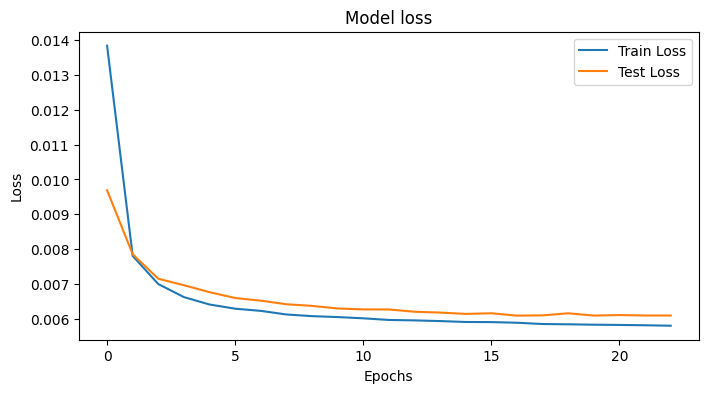

In [72]:
'''Analyzing the loss over time'''
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();

#### Evaluate and save model

In [73]:
result_model = model.evaluate(X_test, Y_test)
result_model

328/328 [==============================] - 1s 2ms/step - loss: 0.0061 - mae: 0.0456 - mse: 0.0059


[0.006086808629333973, 0.0456119142472744, 0.005924244876950979]

In [448]:
tensorflow.saved_model.save(model, 'my_beautiful_model')

INFO:tensorflow:Assets written to: my_beautiful_model/assets


INFO:tensorflow:Assets written to: my_beautiful_model/assets


In [449]:
# loaded_model = keras.models.load_model('my_beautiful_model')
# loaded_model

#### Evaluation metrics

> In regression, we often use metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), etc., to evaluate the model's performance.

In [74]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error (MAE):', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error (RMSE):',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error (MAE):', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error (RMSE):',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

328/328 [==============================] - 1s 2ms/step
Train Mean Absolute Error (MAE): 0.07082480312014727
Train Root Mean Squared Error (RMSE): 0.12585523554812775
Test Mean Absolute Error (MAE): 0.07380007825570765
Test Root Mean Squared Error (RMSE): 0.12453603546038686


#### Plot prediction

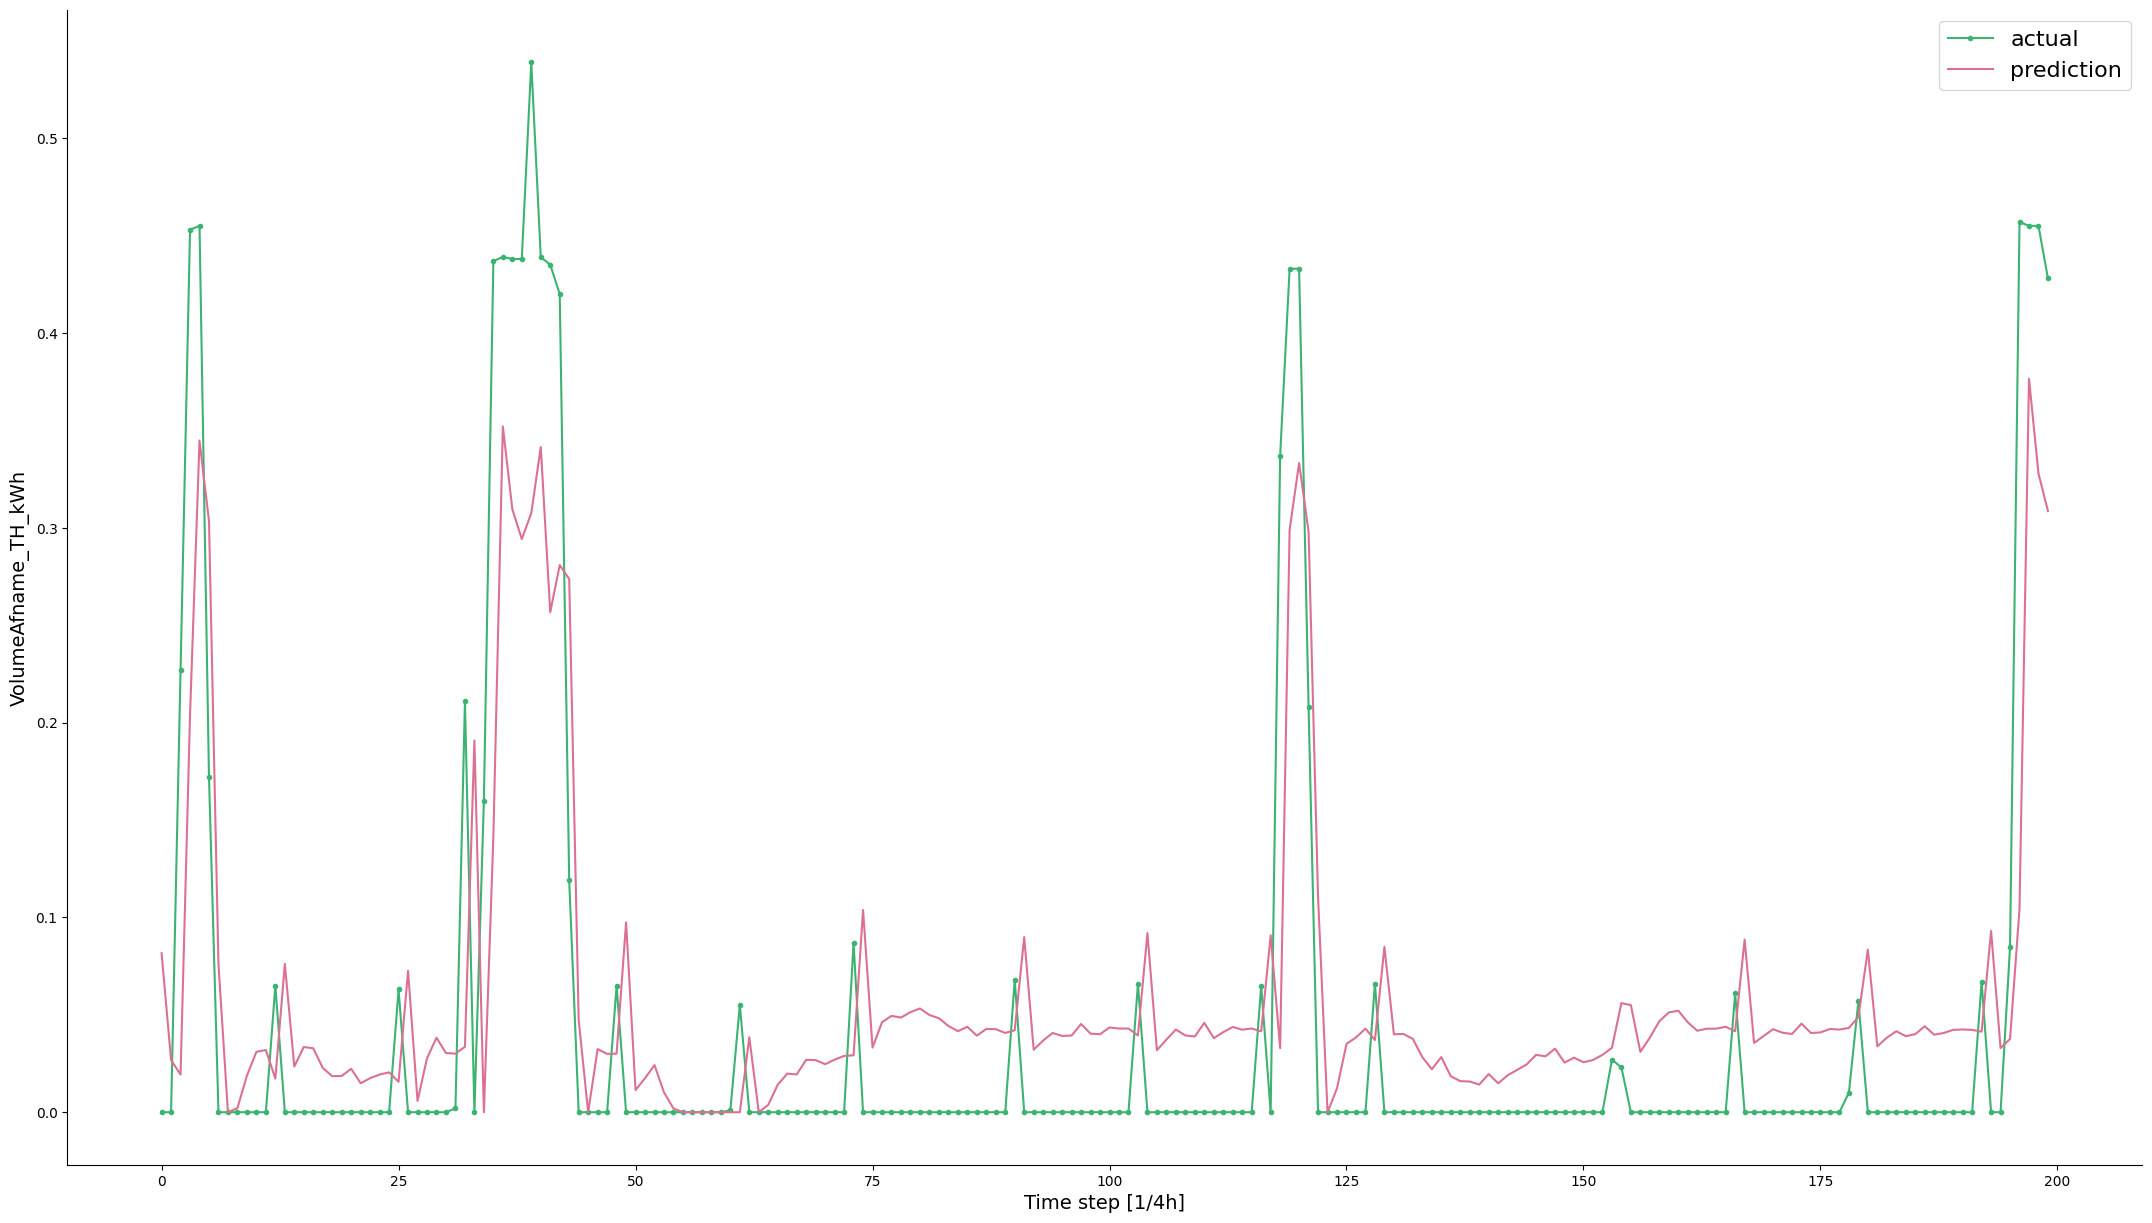

In [75]:
start_interval = 100
end_interval = 300
range_size = end_interval - start_interval

aa=[x for x in range(range_size)]
# Creating a figure object with desired figure size
plt.figure(figsize=(25,15))

# Plotting the actual values in blue with a dot marker
plt.plot(aa, Y_test[0][start_interval:end_interval], marker='.',
         label="actual", color='mediumseagreen')

# Plotting the predicted values in green with a solid line
plt.plot(aa, test_predict[:,0][start_interval:end_interval], '-', 
         label="prediction", color='palevioletred')

# Removing the top spines
sns.despine(top=True)

# Adjusting the subplot location
plt.subplots_adjust(left=0.07)

# Labeling the y-axis
plt.ylabel('VolumeAfname_TH_kWh', size=14)

# Labeling the x-axis
plt.xlabel('Time step [1/4h]', size=14)

# Adding a legend with font size of 15
plt.legend(fontsize=16)

# Display the plot
plt.show()


## LSTM - Production

### Frame the DF to predtict 'VolumeInjectie_TH_kWh' FOR EAN 1

In [452]:
categories = data_EAN['EAN_ID'].unique()

for category in categories:
    sub = data_EAN[data_EAN['EAN_ID'] == category]['VolumeInjectie_TH_kWh'].value_counts()
    print(20*"#",f'{category}', 20*"#")
    print(sub)
"--> EAN 1 has the less number of 0"  

#################### 1 ####################
0.000000    21082
0.003000     1763
0.002000     1166
0.004000     1081
0.001000      832
            ...  
0.078494        1
0.133667        1
0.034696        1
0.056311        1
0.684000        1
Name: VolumeInjectie_TH_kWh, Length: 927, dtype: int64
#################### 2 ####################
0.0    35040
Name: VolumeInjectie_TH_kWh, dtype: int64
#################### 3 ####################
0.0    35040
Name: VolumeInjectie_TH_kWh, dtype: int64
#################### 4 ####################
0.0    35040
Name: VolumeInjectie_TH_kWh, dtype: int64
#################### 5 ####################
0.0    35040
Name: VolumeInjectie_TH_kWh, dtype: int64
#################### 14 ####################
0.000000    23077
0.001000      216
0.002000      173
0.003000      134
0.004000      134
            ...  
0.006725        1
0.009743        1
0.014376        1
0.017950        1
0.669000        1
Name: VolumeInjectie_TH_kWh, Length: 734, dtype: int64
#########

'--> EAN 1 has the less number of 0'

In [291]:
features_creation(data_EAN)

EAN_ID ReadStartDate   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1    2021-01-01 2021-01-01 00:00:00                0.076   
1            1    2021-01-01 2021-01-01 00:15:00                0.048   
2            1    2021-01-01 2021-01-01 00:30:00                0.038   
3            1    2021-01-01 2021-01-01 00:45:00                0.317   
4            1    2021-01-01 2021-01-01 01:00:00                0.570   
...        ...           ...                 ...                  ...   
315355      19    2021-12-31 2021-12-31 22:45:00                0.360   
315356      19    2021-12-31 2021-12-31 23:00:00                0.475   
315357      19    2021-12-31 2021-12-31 23:15:00                0.168   
315358      19    2021-12-31 2021-12-31 23:30:00                0.407   
315359      19    2021-12-31 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  weekday  week_day_timeframe  hour  day  month  \
0                         0.0        1                   4     0    1      1   
1                         0.0        1                   4     0    1      1   
2                         0.0        1                   4     0    1      1   
3                         0.0        1                   4     0    1      1   
4                         0.0        1                   4     1    1      1   
...                       ...      ...                 ...   ...  ...    ...   
315355                    0.0        1                   4    22   31     12   
315356                    0.0        1                   4    23   31     12   
315357                    0.0        1                   4    23   31     12   
315358                    0.0        1                   4    23   31     12   
315359                    0.0        1                   4    23   31     12   

        quarter  year  
0             1  2021  
1             1  2021  
2             1  2021  
3             1  2021  
4             1  2021  
...         ...   ...  
315355        4  2021  
315356        4  2021  
315357        4  2021  
315358        4  2021  
315359        4  2021  

[315360 rows x 12 columns]

In [292]:
# Apply the time_frame function to create the 'Time_frame' HI/LO column
data_EAN['Time_Frame'] = data_EAN.apply(time_frame, axis=1)
data_EAN.drop(columns=['week_day_timeframe'],inplace=True) 
data_EAN

EAN_ID ReadStartDate   ReadStartDateTime  VolumeAfname_TH_kWh  \
0            1    2021-01-01 2021-01-01 00:00:00                0.076   
1            1    2021-01-01 2021-01-01 00:15:00                0.048   
2            1    2021-01-01 2021-01-01 00:30:00                0.038   
3            1    2021-01-01 2021-01-01 00:45:00                0.317   
4            1    2021-01-01 2021-01-01 01:00:00                0.570   
...        ...           ...                 ...                  ...   
315355      19    2021-12-31 2021-12-31 22:45:00                0.360   
315356      19    2021-12-31 2021-12-31 23:00:00                0.475   
315357      19    2021-12-31 2021-12-31 23:15:00                0.168   
315358      19    2021-12-31 2021-12-31 23:30:00                0.407   
315359      19    2021-12-31 2021-12-31 23:45:00                0.148   

        VolumeInjectie_TH_kWh  weekday  hour  day  month  quarter  year  \
0                         0.0        1     0    1      1        1  2021   
1                         0.0        1     0    1      1        1  2021   
2                         0.0        1     0    1      1        1  2021   
3                         0.0        1     0    1      1        1  2021   
4                         0.0        1     1    1      1        1  2021   
...                       ...      ...   ...  ...    ...      ...   ...   
315355                    0.0        1    22   31     12        4  2021   
315356                    0.0        1    23   31     12        4  2021   
315357                    0.0        1    23   31     12        4  2021   
315358                    0.0        1    23   31     12        4  2021   
315359                    0.0        1    23   31     12        4  2021   

       Time_Frame  
0              LO  
1              LO  
2              LO  
3              LO  
4              LO  
...           ...  
315355         LO  
315356         LO  
315357         LO  
315358         LO  
315359         LO  

[315360 rows x 12 columns]

In [294]:
"""Set/Reset dates as index before resampling"""
data_EAN.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_EAN.reset_index(inplace=True) # Comment/uncomment this row or the previous one
data_EAN

EAN_ID ReadStartDate  VolumeAfname_TH_kWh  \
ReadStartDateTime                                                
2021-01-01 00:00:00       1    2021-01-01                0.076   
2021-01-01 00:15:00       1    2021-01-01                0.048   
2021-01-01 00:30:00       1    2021-01-01                0.038   
2021-01-01 00:45:00       1    2021-01-01                0.317   
2021-01-01 01:00:00       1    2021-01-01                0.570   
...                     ...           ...                  ...   
2021-12-31 22:45:00      19    2021-12-31                0.360   
2021-12-31 23:00:00      19    2021-12-31                0.475   
2021-12-31 23:15:00      19    2021-12-31                0.168   
2021-12-31 23:30:00      19    2021-12-31                0.407   
2021-12-31 23:45:00      19    2021-12-31                0.148   

                     VolumeInjectie_TH_kWh  weekday  hour  day  month  \
ReadStartDateTime                                                       
2021-01-01 00:00:00                    0.0        1     0    1      1   
2021-01-01 00:15:00                    0.0        1     0    1      1   
2021-01-01 00:30:00                    0.0        1     0    1      1   
2021-01-01 00:45:00                    0.0        1     0    1      1   
2021-01-01 01:00:00                    0.0        1     1    1      1   
...                                    ...      ...   ...  ...    ...   
2021-12-31 22:45:00                    0.0        1    22   31     12   
2021-12-31 23:00:00                    0.0        1    23   31     12   
2021-12-31 23:15:00                    0.0        1    23   31     12   
2021-12-31 23:30:00                    0.0        1    23   31     12   
2021-12-31 23:45:00                    0.0        1    23   31     12   

                     quarter  year Time_Frame  
ReadStartDateTime                              
2021-01-01 00:00:00        1  2021         LO  
2021-01-01 00:15:00        1  2021         LO  
2021-01-01 00:30:00        1  2021         LO  
2021-01-01 00:45:00        1  2021         LO  
2021-01-01 01:00:00        1  2021         LO  
...                      ...   ...        ...  
2021-12-31 22:45:00        4  2021         LO  
2021-12-31 23:00:00        4  2021         LO  
2021-12-31 23:15:00        4  2021         LO  
2021-12-31 23:30:00        4  2021         LO  
2021-12-31 23:45:00        4  2021         LO  

[315360 rows x 11 columns]

In [295]:
data_EAN_1_inject = data_EAN[data_EAN['EAN_ID'] == 1]
data_framed_injection = data_EAN_1_inject[['VolumeInjectie_TH_kWh', 'weekday', 'hour', 'day', 
                       'month', 'quarter','year', 'Time_Frame']]
data_framed_injection

VolumeInjectie_TH_kWh  weekday  hour  day  month  \
ReadStartDateTime                                                       
2021-01-01 00:00:00                    0.0        1     0    1      1   
2021-01-01 00:15:00                    0.0        1     0    1      1   
2021-01-01 00:30:00                    0.0        1     0    1      1   
2021-01-01 00:45:00                    0.0        1     0    1      1   
2021-01-01 01:00:00                    0.0        1     1    1      1   
...                                    ...      ...   ...  ...    ...   
2021-12-31 22:45:00                    0.0        1    22   31     12   
2021-12-31 23:00:00                    0.0        1    23   31     12   
2021-12-31 23:15:00                    0.0        1    23   31     12   
2021-12-31 23:30:00                    0.0        1    23   31     12   
2021-12-31 23:45:00                    0.0        1    23   31     12   

                     quarter  year Time_Frame  
ReadStartDateTime                              
2021-01-01 00:00:00        1  2021         LO  
2021-01-01 00:15:00        1  2021         LO  
2021-01-01 00:30:00        1  2021         LO  
2021-01-01 00:45:00        1  2021         LO  
2021-01-01 01:00:00        1  2021         LO  
...                      ...   ...        ...  
2021-12-31 22:45:00        4  2021         LO  
2021-12-31 23:00:00        4  2021         LO  
2021-12-31 23:15:00        4  2021         LO  
2021-12-31 23:30:00        4  2021         LO  
2021-12-31 23:45:00        4  2021         LO  

[35040 rows x 8 columns]

### Modelling

# Case for the replacement of the water heater

## Let's do some checks : Water heater

In [45]:
url = "/mnt/c/Users/qwout/Documents/Emplois/Thermovault/P-data-2023-04-04 12_20_17.csv"
data_wh = pd.read_csv(url)
data_wh = data_wh.copy()
data_wh['Time'] = pd.to_datetime(data_wh['Time'], unit='ms')  # 'unit' specifies that the timestamps are in seconds
data_wh.rename(columns={"Time": "ReadStartDateTime"},inplace=True)
data_wh.rename(columns={"P": "Power[W]"},inplace=True)
display(data_wh)
display(data_wh.info())

ReadStartDateTime  Power[W]
0      2022-01-01 00:02:26.367         0
1      2022-01-01 00:07:26.406         0
2      2022-01-01 00:12:26.441         0
3      2022-01-01 00:17:26.476         0
4      2022-01-01 00:22:26.507         0
...                        ...       ...
105478 2022-12-30 15:43:31.007         0
105479 2022-12-30 15:48:31.074         0
105480 2022-12-30 15:53:31.136         0
105481 2022-12-30 15:58:32.300         0
105482 2022-12-30 15:58:32.310         0

[105483 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105483 entries, 0 to 105482
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ReadStartDateTime  105483 non-null  datetime64[ns]
 1   Power[W]           105483 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 MB


None

> It is very important to use the closed='left' and label='right' arguments correctly to avoid introducing future information into the training. It would lead to leakage. 

> Suppose that values are available for 10:10, 10:30, 10:45, 11:00, 11:12, and 11:30. To obtain the hourly average : 
> - The value assigned to 11:00 must be calculated using the values for 10:10, 10:30, and 10:45 
> - The value assigned to 12:00 must be calculated using the value for 11:00, 11:12 and 11:30.

In [46]:
'''MUST set the datetime column as the index BEFORE RESAMPLING'''
data_wh.set_index('ReadStartDateTime', inplace=True)
# Resample to a quarter-hour frequency and perform aggregation (e.g., count)
data_wh_resampled = data_wh.resample(rule='15T', closed='left', label ='right').mean()
data_wh_resampled.reset_index(inplace=True)
display(data_wh_resampled)
display(data_wh_resampled.info())

ReadStartDateTime  Power[W]
0     2022-01-01 00:15:00       0.0
1     2022-01-01 00:30:00       0.0
2     2022-01-01 00:45:00       0.0
3     2022-01-01 01:00:00       0.0
4     2022-01-01 01:15:00       0.0
...                   ...       ...
34907 2022-12-30 15:00:00       0.0
34908 2022-12-30 15:15:00       0.0
34909 2022-12-30 15:30:00       0.0
34910 2022-12-30 15:45:00       0.0
34911 2022-12-30 16:00:00       0.0

[34912 rows x 2 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34912 entries, 0 to 34911
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ReadStartDateTime  34912 non-null  datetime64[ns]
 1   Power[W]           33173 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 545.6 KB


None

In [79]:
data_wh_resampled['Power[W]'].value_counts()

0.000000       29037
2.750000         165
2.500000         147
3.000000          76
5.750000          64
               ...  
1379.800000        1
1936.142857        1
1794.400000        1
1665.250000        1
472.000000         1
Name: Power[W], Length: 2023, dtype: int64

## Let's do some checks : EAN 14

In [43]:
"""Select the EAN [1, 2, 3, 4, 5, 14, 16, 17, 19], no taking into account the TZ """
data_EAN_14 = data[data['EAN_ID'].isin([14])]  # Selected households EANGSRN
data_EAN_14['ReadStartDate'] = pd.to_datetime(data_EAN_14['ReadStartDate'])  # Convert to datetime
data_EAN_14['ReadStartDateTime'] = data_EAN_14['ReadStartDateTime'].apply(lambda x: x[:-5])  # If we don't want to take the TimeZone into account
data_EAN_14['ReadStartDateTime'] = pd.to_datetime(data_EAN_14['ReadStartDateTime'])  # Convert to datetime
data_EAN_14.reset_index(drop=True, inplace=True)  # drop = True : does not add the new column of the current row index in the DF
display(data_EAN_14)
display(data_EAN_14.info())

/tmp/ipykernel_3546/415514284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_EAN_14['ReadStartDate'] = pd.to_datetime(data_EAN_14['ReadStartDate'])  # Convert to datetime
/tmp/ipykernel_3546/415514284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_EAN_14['ReadStartDateTime'] = data_EAN_14['ReadStartDateTime'].apply(lambda x: x[:-5])  # If we don't want to take the TimeZone into account
/tmp/ipykernel_3546/415514284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

EAN_ID ReadStartDate   ReadStartDateTime  VolumeAfname_TH_kWh  \
0          14    2021-01-01 2021-01-01 00:00:00                0.020   
1          14    2021-01-01 2021-01-01 00:15:00                0.028   
2          14    2021-01-01 2021-01-01 00:30:00                0.035   
3          14    2021-01-01 2021-01-01 00:45:00                0.017   
4          14    2021-01-01 2021-01-01 01:00:00                0.020   
...       ...           ...                 ...                  ...   
35035      14    2021-12-31 2021-12-31 22:45:00                0.020   
35036      14    2021-12-31 2021-12-31 23:00:00                0.030   
35037      14    2021-12-31 2021-12-31 23:15:00                0.029   
35038      14    2021-12-31 2021-12-31 23:30:00                0.022   
35039      14    2021-12-31 2021-12-31 23:45:00                0.020   

       VolumeInjectie_TH_kWh  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...                      ...  
35035                    0.0  
35036                    0.0  
35037                    0.0  
35038                    0.0  
35039                    0.0  

[35040 rows x 5 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   EAN_ID                 35040 non-null  int64         
 1   ReadStartDate          35040 non-null  datetime64[ns]
 2   ReadStartDateTime      35040 non-null  datetime64[ns]
 3   VolumeAfname_TH_kWh    35040 non-null  float64       
 4   VolumeInjectie_TH_kWh  35040 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 1.3 MB


None

## Merge EAN 14 & Water Heater 

In [55]:
# data_EAN_14.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_EAN_14.reset_index(inplace=True) # Comment/uncomment this row or the previous one
data_EAN_14 = data_EAN_14.copy()
data_EAN_14

EAN_ID ReadStartDate   ReadStartDateTime  VolumeAfname_TH_kWh  \
0          14    2021-01-01 2021-01-01 00:00:00                0.020   
1          14    2021-01-01 2021-01-01 00:15:00                0.028   
2          14    2021-01-01 2021-01-01 00:30:00                0.035   
3          14    2021-01-01 2021-01-01 00:45:00                0.017   
4          14    2021-01-01 2021-01-01 01:00:00                0.020   
...       ...           ...                 ...                  ...   
35035      14    2021-12-31 2021-12-31 22:45:00                0.020   
35036      14    2021-12-31 2021-12-31 23:00:00                0.030   
35037      14    2021-12-31 2021-12-31 23:15:00                0.029   
35038      14    2021-12-31 2021-12-31 23:30:00                0.022   
35039      14    2021-12-31 2021-12-31 23:45:00                0.020   

       VolumeInjectie_TH_kWh  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...                      ...  
35035                    0.0  
35036                    0.0  
35037                    0.0  
35038                    0.0  
35039                    0.0  

[35040 rows x 5 columns]

In [56]:
# data_wh_resampled.set_index('ReadStartDateTime',inplace=True) # Comment/uncomment this row or the next one
# data_wh_resampled.reset_index(inplace=True) # Comment/uncomment this row or the previous one
data_wh_resampled = data_wh_resampled.copy()
data_wh_resampled

ReadStartDateTime  Power[W]
0     2021-01-01 00:15:00       0.0
1     2021-01-01 00:30:00       0.0
2     2021-01-01 00:45:00       0.0
3     2021-01-01 01:00:00       0.0
4     2021-01-01 01:15:00       0.0
...                   ...       ...
34907 2021-12-30 15:00:00       0.0
34908 2021-12-30 15:15:00       0.0
34909 2021-12-30 15:30:00       0.0
34910 2021-12-30 15:45:00       0.0
34911 2021-12-30 16:00:00       0.0

[34912 rows x 2 columns]

In [57]:
"""The entire data of the water heate's power is over 2022, it doesn't make sens if 
I want to compare with the EAN = 14 which has all data over 2021 """

"The entire data of the water heate's power is over 2022, it doesn't make sens if \nI want to compare with the EAN = 14 which has all data over 2021 "

In [58]:
def update_year(date):
    if date.year == 2022:
        return date.replace(year=2021)
    return date

# Apply the function to the 'dates' column
data_wh_resampled['ReadStartDateTime'] = data_wh_resampled['ReadStartDateTime'].apply(update_year)
data_wh_resampled_2021 = data_wh_resampled
data_wh_resampled_2021

ReadStartDateTime  Power[W]
0     2021-01-01 00:15:00       0.0
1     2021-01-01 00:30:00       0.0
2     2021-01-01 00:45:00       0.0
3     2021-01-01 01:00:00       0.0
4     2021-01-01 01:15:00       0.0
...                   ...       ...
34907 2021-12-30 15:00:00       0.0
34908 2021-12-30 15:15:00       0.0
34909 2021-12-30 15:30:00       0.0
34910 2021-12-30 15:45:00       0.0
34911 2021-12-30 16:00:00       0.0

[34912 rows x 2 columns]

In [59]:
def time_frame_price(row):
    if (6 <= row['ReadStartDateTime'].hour < 22) and (row['week_day'] <= 5):
        return 0.025
    else:
        return 0.018  # You can choose what to do in other cases

In [ ]:
def time_frame(row):
    if (6 <= row['ReadStartDateTime'].hour < 22) and (row['week_day'] <= 5):
        return 'HI'
    else:
        return 'LO'  # You can choose what to do in other cases

In [459]:
merge = pd.merge(data_EAN_14, data_wh_resampled_2021, how='left',
                 on='ReadStartDateTime')
merge['Energy_Water_Heater[kWh]'] = merge['Power[W]']/4000
# merge.rename(columns={"Power[kWh]": "Energy_Water_Heater[kWh]"},inplace=True)
merge.drop(columns=['Power[W]','ReadStartDate'],inplace=True)

# Formula to calculatethe fraction of the water heater consumption is served directly from solar production (SP)
# merge['Water_Heater_from_PV'] = merge['Energy_Water_Heater[kWh]'] + merge['VolumeAfname_TH_kWh'] - merge['VolumeInjectie_TH_kWh']
# merge['Water_Heater_from_SP'] = merge['Energy_Water_Heater[kWh]'] - merge['VolumeInjectie_TH_kWh']

""" week days (Monday=0 to Friday=5) & week-end days (Saturday = 6, Sunday = 7)"""
merge['week_day'] = merge['ReadStartDateTime'].dt.dayofweek

"""column day of week or day of week-end"""
merge['week_day/wee_end_day'] = merge['week_day'].apply(lambda x: 'week_end' if x > 5 else 'week_day')

# Apply the time_frame function to create the 'Time_frame' and 'Time_frame_price' HI/LO column
merge['Time_Frame'] = merge.apply(time_frame, axis=1)
merge['Time_Frame_price_consumption'] = merge.apply(time_frame_price, axis=1)
merge['Time_Frame_price_injection'] = 0.05
merge.head(50)

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0       14 2021-01-01 00:00:00                0.020                  0.000   
1       14 2021-01-01 00:15:00                0.028                  0.000   
2       14 2021-01-01 00:30:00                0.035                  0.000   
3       14 2021-01-01 00:45:00                0.017                  0.000   
4       14 2021-01-01 01:00:00                0.020                  0.000   
5       14 2021-01-01 01:15:00                0.040                  0.000   
6       14 2021-01-01 01:30:00                0.018                  0.000   
7       14 2021-01-01 01:45:00                0.019                  0.000   
8       14 2021-01-01 02:00:00                0.032                  0.000   
9       14 2021-01-01 02:15:00                0.025                  0.000   
10      14 2021-01-01 02:30:00                0.019                  0.000   
11      14 2021-01-01 02:45:00                0.023                  0.000   
12      14 2021-01-01 03:00:00                0.033                  0.000   
13      14 2021-01-01 03:15:00                0.024                  0.000   
14      14 2021-01-01 03:30:00                0.044                  0.000   
15      14 2021-01-01 03:45:00                0.053                  0.000   
16      14 2021-01-01 04:00:00                0.048                  0.000   
17      14 2021-01-01 04:15:00                0.044                  0.000   
18      14 2021-01-01 04:30:00                0.044                  0.000   
19      14 2021-01-01 04:45:00                0.057                  0.000   
20      14 2021-01-01 05:00:00                0.044                  0.000   
21      14 2021-01-01 05:15:00                0.040                  0.000   
22      14 2021-01-01 05:30:00                0.055                  0.000   
23      14 2021-01-01 05:45:00                0.049                  0.000   
24      14 2021-01-01 06:00:00                0.040                  0.000   
25      14 2021-01-01 06:15:00                0.049                  0.000   
26      14 2021-01-01 06:30:00                0.055                  0.000   
27      14 2021-01-01 06:45:00                0.041                  0.000   
28      14 2021-01-01 07:00:00                0.042                  0.000   
29      14 2021-01-01 07:15:00                0.077                  0.000   
30      14 2021-01-01 07:30:00                0.391                  0.000   
31      14 2021-01-01 07:45:00                0.600                  0.000   
32      14 2021-01-01 08:00:00                0.611                  0.000   
33      14 2021-01-01 08:15:00                0.137                  0.000   
34      14 2021-01-01 08:30:00                0.109                  0.000   
35      14 2021-01-01 08:45:00                0.095                  0.000   
36      14 2021-01-01 09:00:00                0.069                  0.000   
37      14 2021-01-01 09:15:00                0.046                  0.000   
38      14 2021-01-01 09:30:00                0.072                  0.000   
39      14 2021-01-01 09:45:00                0.034                  0.000   
40      14 2021-01-01 10:00:00                0.447                  0.000   
41      14 2021-01-01 10:15:00                0.495                  0.000   
42      14 2021-01-01 10:30:00                0.761                  0.000   
43      14 2021-01-01 10:45:00                0.571                  0.002   
44      14 2021-01-01 11:00:00                0.000                  0.089   
45      14 2021-01-01 11:15:00                0.000                  0.126   
46      14 2021-01-01 11:30:00                0.000                  0.142   
47      14 2021-01-01 11:45:00                0.000                  0.196   
48      14 2021-01-01 12:00:00                0.000                  0.226   
49      14 2021-01-01 12:15:00                0.000                  0.131   

    Energy_Water_Heater[k

## MERGE READY

In [460]:
# pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows', None)

merge_set = merge.copy()
merge_set

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
0          14 2021-01-01 00:00:00                0.020                    0.0   
1          14 2021-01-01 00:15:00                0.028                    0.0   
2          14 2021-01-01 00:30:00                0.035                    0.0   
3          14 2021-01-01 00:45:00                0.017                    0.0   
4          14 2021-01-01 01:00:00                0.020                    0.0   
...       ...                 ...                  ...                    ...   
35035      14 2021-12-31 22:45:00                0.020                    0.0   
35036      14 2021-12-31 23:00:00                0.030                    0.0   
35037      14 2021-12-31 23:15:00                0.029                    0.0   
35038      14 2021-12-31 23:30:00                0.022                    0.0   
35039      14 2021-12-31 23:45:00                0.020                    0.0   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
0                           NaN         4             week_day         LO   
1                           0.0         4             week_day         LO   
2                           0.0         4             week_day         LO   
3                           0.0         4             week_day         LO   
4                           0.0         4             week_day         LO   
...                         ...       ...                  ...        ...   
35035                       NaN         4             week_day         LO   
35036                       NaN         4             week_day         LO   
35037                       NaN         4             week_day         LO   
35038                       NaN         4             week_day         LO   
35039                       NaN         4             week_day         LO   

       Time_Frame_price_consumption  Time_Frame_price_injection  
0                             0.018                        0.05  
1                             0.018                        0.05  
2                             0.018                        0.05  
3                             0.018                        0.05  
4                             0.018                        0.05  
...                             ...                         ...  
35035                         0.018                        0.05  
35036                         0.018                        0.05  
35037                         0.018                        0.05  
35038                         0.018                        0.05  
35039                         0.018                        0.05  

[35040 rows x 10 columns]

In [461]:
merge_set.columns

Index(['EAN_ID', 'ReadStartDateTime', 'VolumeAfname_TH_kWh',
       'VolumeInjectie_TH_kWh', 'Energy_Water_Heater[kWh]', 'week_day',
       'week_day/wee_end_day', 'Time_Frame', 'Time_Frame_price_consumption',
       'Time_Frame_price_injection'],
      dtype='object')

### Fraction of the water heater consumption covered by solar productio(SP)

In [462]:
# (merge.loc[(merge['VolumeInjectie_TH_kWh'] != 0) 
#       & ((merge['Energy_Water_Heater[kWh]'] != 0.0) > (merge['VolumeAfname_TH_kWh']))].dropna())['Energy_Water_Heater[kWh]'].value_counts()

#### Scenario1: A- != 0 & [(Conso_wh != 0) & > (A+)]

In [463]:
condition_inject_diff_0 = (merge['VolumeInjectie_TH_kWh'] != 0)
condition_bigger = (merge['Energy_Water_Heater[kWh]'] !=0) & ((merge['Energy_Water_Heater[kWh]']) > (merge['VolumeAfname_TH_kWh']))
selected_rows_scenario1 = merge[condition_inject_diff_0 & condition_bigger]
display(selected_rows_scenario1['Energy_Water_Heater[kWh]'].count())
selected_rows_scenario1.dropna()

1093

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
48         14 2021-01-01 12:00:00                0.000                  0.226   
49         14 2021-01-01 12:15:00                0.000                  0.131   
50         14 2021-01-01 12:30:00                0.002                  0.085   
133        14 2021-01-02 09:15:00                0.000                  0.010   
328        14 2021-01-04 10:00:00                0.013                  0.001   
...       ...                 ...                  ...                    ...   
32506      14 2021-12-05 14:30:00                0.023                  0.014   
32693      14 2021-12-07 13:15:00                0.000                  0.014   
33365      14 2021-12-14 13:15:00                0.005                  0.001   
33845      14 2021-12-19 13:15:00                0.006                  0.002   
34901      14 2021-12-30 13:15:00                0.000                  0.027   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
48                     0.346450         4             week_day         HI   
49                     0.568083         4             week_day         HI   
50                     0.144125         4             week_day         HI   
133                    0.558450         5             week_day         HI   
328                    0.456750         0             week_day         HI   
...                         ...       ...                  ...        ...   
32506                  0.226650         6             week_end         LO   
32693                  0.113750         1             week_day         HI   
33365                  0.116800         1             week_day         HI   
33845                  0.571250         6             week_end         LO   
34901                  0.118000         3             week_day         HI   

       Time_Frame_price_consumption  Time_Frame_price_injection  
48                            0.025                        0.05  
49                            0.025                        0.05  
50                            0.025                        0.05  
133                           0.025                        0.05  
328                           0.025                        0.05  
...                             ...                         ...  
32506                         0.018                        0.05  
32693                         0.025                        0.05  
33365                         0.025                        0.05  
33845                         0.018                        0.05  
34901                         0.025                        0.05  

[1093 rows x 10 columns]

> Note that the water heater energy's is bigger than the consumption A+, so some energy must come from the SP. Indeed, let assume that because the household injects on the grid, all its energy demand is covered, then the fraction of the water heater consumption is one part covered by the consumption A+ from the grid and the other part is covered by the SP

In [464]:
selected_rows_scenario1 = selected_rows_scenario1.copy()
selected_rows_scenario1['fraction_SP'] = abs((selected_rows_scenario1['VolumeAfname_TH_kWh']) - (selected_rows_scenario1['Energy_Water_Heater[kWh]'])) 
display(selected_rows_scenario1)
print(f'The total fraction of water heater consutmpion served from SP is {selected_rows_scenario1["fraction_SP"].sum()} kWh or {selected_rows_scenario1["fraction_SP"].sum()*4} kW ')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
48         14 2021-01-01 12:00:00                0.000                  0.226   
49         14 2021-01-01 12:15:00                0.000                  0.131   
50         14 2021-01-01 12:30:00                0.002                  0.085   
133        14 2021-01-02 09:15:00                0.000                  0.010   
328        14 2021-01-04 10:00:00                0.013                  0.001   
...       ...                 ...                  ...                    ...   
32506      14 2021-12-05 14:30:00                0.023                  0.014   
32693      14 2021-12-07 13:15:00                0.000                  0.014   
33365      14 2021-12-14 13:15:00                0.005                  0.001   
33845      14 2021-12-19 13:15:00                0.006                  0.002   
34901      14 2021-12-30 13:15:00                0.000                  0.027   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
48                     0.346450         4             week_day         HI   
49                     0.568083         4             week_day         HI   
50                     0.144125         4             week_day         HI   
133                    0.558450         5             week_day         HI   
328                    0.456750         0             week_day         HI   
...                         ...       ...                  ...        ...   
32506                  0.226650         6             week_end         LO   
32693                  0.113750         1             week_day         HI   
33365                  0.116800         1             week_day         HI   
33845                  0.571250         6             week_end         LO   
34901                  0.118000         3             week_day         HI   

       Time_Frame_price_consumption  Time_Frame_price_injection  fraction_SP  
48                            0.025                        0.05     0.346450  
49                            0.025                        0.05     0.568083  
50                            0.025                        0.05     0.142125  
133                           0.025                        0.05     0.558450  
328                           0.025                        0.05     0.443750  
...                             ...                         ...          ...  
32506                         0.018                        0.05     0.203650  
32693                         0.025                        0.05     0.113750  
33365                         0.025                        0.05     0.111800  
33845                         0.018                        0.05     0.565250  
34901                         0.025                        0.05     0.118000  

[1093 rows x 11 columns]

The total fraction of water heater consutmpion served from SP is 380.4565913575036 kWh or 1521.8263654300144 kW 


#### Scenario2: A- != 0 & [(Conso_wh != 0) & < (A+)]

In [465]:
condition_inject_diff_0 = (merge['VolumeInjectie_TH_kWh'] != 0)
condition_smaller = (merge['Energy_Water_Heater[kWh]'] !=0) & ((merge['Energy_Water_Heater[kWh]']) < (merge['VolumeAfname_TH_kWh']))
selected_rows_scenario2 = merge[condition_inject_diff_0 & condition_smaller]
display(selected_rows_scenario2['Energy_Water_Heater[kWh]'].count())
selected_rows_scenario2

57

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
134        14 2021-01-02 09:30:00             0.004000               0.002000   
538        14 2021-01-06 14:30:00             0.001000               0.009000   
620        14 2021-01-07 11:00:00             0.002000               0.006000   
1397       14 2021-01-15 13:15:00             0.033000               0.021000   
1589       14 2021-01-17 13:15:00             0.128000               0.003000   
1591       14 2021-01-17 13:45:00             0.013000               0.005000   
1962       14 2021-01-21 10:30:00             0.098000               0.027000   
3209       14 2021-02-03 10:15:00             0.131000               0.012000   
3510       14 2021-02-06 13:30:00             0.002000               0.034000   
4268       14 2021-02-14 11:00:00             0.216000               0.083000   
4468       14 2021-02-16 13:00:00             0.357000               0.006000   
4477       14 2021-02-16 15:15:00             0.051000               0.021000   
4547       14 2021-02-17 08:45:00             0.069000               0.022000   
5441       14 2021-02-26 16:15:00             0.011000               0.031000   
5820       14 2021-03-02 15:00:00             0.031000               0.149000   
6114       14 2021-03-05 16:30:00             0.002000               0.052000   
6288       14 2021-03-07 12:00:00             0.029000               0.442000   
6474       14 2021-03-09 10:30:00             0.210287               0.022345   
6869       14 2021-03-13 13:15:00             0.104000               0.164000   
7437       14 2021-03-19 11:15:00             0.001000               0.407000   
7539       14 2021-03-20 12:45:00             0.001000               0.026000   
7628       14 2021-03-21 11:00:00             0.086000               0.152000   
8517       14 2021-03-30 17:15:00             0.002000               0.015000   
8705       14 2021-04-01 16:15:00             0.206000               0.044000   
9084       14 2021-04-05 15:00:00             0.405000               0.297000   
9445       14 2021-04-09 09:15:00             0.071000               0.139000   
9472       14 2021-04-09 16:00:00             0.164000               0.053000   
9638       14 2021-04-11 09:30:00             0.240000               0.038000   
11104      14 2021-04-26 16:00:00             0.372000               0.001000   
11370      14 2021-04-29 10:30:00             0.018000               0.160000   
11937      14 2021-05-05 08:15:00             0.001000               0.154000   
12595      14 2021-05-12 04:45:00             0.004000               0.002000   
12604      14 2021-05-12 07:00:00             0.318000               0.009000   
13077      14 2021-05-17 05:15:00             0.012000               0.002000   
13316      14 2021-05-19 17:00:00             0.055000               0.043000   
13561      14 2021-05-22 06:15:00             0.023000               0.002000   
14080      14 2021-05-27 16:00:00             0.431000               0.015000   
14330      14 2021-05-30 06:30:00             0.220000               0.050000   
14335      14 2021-05-30 07:45:00             0.147000               0.050000   
15234      14 2021-06-08 16:30:00             0.001000               0.059000   
15871      14 2021-06-15 07:45:00             0.287000               0.017000   
17035      14 2021-06-27 10:45:00             0.014000               0.077000   
17152      14 2021-06-28 16:00:00             0.383000               0.094000   
17219      14 2021-06-29 08:45:00             0.121000               0.086000   
17311      14 2021-06-30 07:45:00             0.002000               0.140000   
17712      14 2021-07-04 12:00:00             0.357000               0.014000   
17891      14 2021-07-06 08:45:00             0.243000               0.007000   
21384      14 2021-08-11 18:00:00             0.004000               0.006000   
25213      14 2021-09-20 15:15:00     

> Let assume that because the household injects on the grid, all its energy demand is covered. But, the household consumes ass well (A+). The consumption of the water heater could be covered either by A+ or by the SP.  

> Let assume that the entire consumption of the water heater is covered by the SP

In [466]:
selected_rows_scenario2 = selected_rows_scenario2.copy()
selected_rows_scenario2['fraction_SP'] = abs((selected_rows_scenario2['Energy_Water_Heater[kWh]']))
display(selected_rows_scenario2)
print(f'The total fraction of water heater consumption convered by the SP is {selected_rows_scenario2["fraction_SP"].sum()} kWh or {selected_rows_scenario2["fraction_SP"].sum()*4} kW ')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
134        14 2021-01-02 09:30:00             0.004000               0.002000   
538        14 2021-01-06 14:30:00             0.001000               0.009000   
620        14 2021-01-07 11:00:00             0.002000               0.006000   
1397       14 2021-01-15 13:15:00             0.033000               0.021000   
1589       14 2021-01-17 13:15:00             0.128000               0.003000   
1591       14 2021-01-17 13:45:00             0.013000               0.005000   
1962       14 2021-01-21 10:30:00             0.098000               0.027000   
3209       14 2021-02-03 10:15:00             0.131000               0.012000   
3510       14 2021-02-06 13:30:00             0.002000               0.034000   
4268       14 2021-02-14 11:00:00             0.216000               0.083000   
4468       14 2021-02-16 13:00:00             0.357000               0.006000   
4477       14 2021-02-16 15:15:00             0.051000               0.021000   
4547       14 2021-02-17 08:45:00             0.069000               0.022000   
5441       14 2021-02-26 16:15:00             0.011000               0.031000   
5820       14 2021-03-02 15:00:00             0.031000               0.149000   
6114       14 2021-03-05 16:30:00             0.002000               0.052000   
6288       14 2021-03-07 12:00:00             0.029000               0.442000   
6474       14 2021-03-09 10:30:00             0.210287               0.022345   
6869       14 2021-03-13 13:15:00             0.104000               0.164000   
7437       14 2021-03-19 11:15:00             0.001000               0.407000   
7539       14 2021-03-20 12:45:00             0.001000               0.026000   
7628       14 2021-03-21 11:00:00             0.086000               0.152000   
8517       14 2021-03-30 17:15:00             0.002000               0.015000   
8705       14 2021-04-01 16:15:00             0.206000               0.044000   
9084       14 2021-04-05 15:00:00             0.405000               0.297000   
9445       14 2021-04-09 09:15:00             0.071000               0.139000   
9472       14 2021-04-09 16:00:00             0.164000               0.053000   
9638       14 2021-04-11 09:30:00             0.240000               0.038000   
11104      14 2021-04-26 16:00:00             0.372000               0.001000   
11370      14 2021-04-29 10:30:00             0.018000               0.160000   
11937      14 2021-05-05 08:15:00             0.001000               0.154000   
12595      14 2021-05-12 04:45:00             0.004000               0.002000   
12604      14 2021-05-12 07:00:00             0.318000               0.009000   
13077      14 2021-05-17 05:15:00             0.012000               0.002000   
13316      14 2021-05-19 17:00:00             0.055000               0.043000   
13561      14 2021-05-22 06:15:00             0.023000               0.002000   
14080      14 2021-05-27 16:00:00             0.431000               0.015000   
14330      14 2021-05-30 06:30:00             0.220000               0.050000   
14335      14 2021-05-30 07:45:00             0.147000               0.050000   
15234      14 2021-06-08 16:30:00             0.001000               0.059000   
15871      14 2021-06-15 07:45:00             0.287000               0.017000   
17035      14 2021-06-27 10:45:00             0.014000               0.077000   
17152      14 2021-06-28 16:00:00             0.383000               0.094000   
17219      14 2021-06-29 08:45:00             0.121000               0.086000   
17311      14 2021-06-30 07:45:00             0.002000               0.140000   
17712      14 2021-07-04 12:00:00             0.357000               0.014000   
17891      14 2021-07-06 08:45:00             0.243000               0.007000   
21384      14 2021-08-11 18:00:00             0.004000               0.006000   
25213      14 2021-09-20 15:15:00     

The total fraction of water heater consumption convered by the SP is 2.341683928571429 kWh or 9.366735714285715 kW 


#### Scenario3: A- = 0 & [(Conso_wh != 0) & > (A+)]

In [467]:
condition_inject_0 = (merge['VolumeInjectie_TH_kWh'] == 0)
condition_bigger = (merge['Energy_Water_Heater[kWh]'] !=0) & ((merge['Energy_Water_Heater[kWh]']) > (merge['VolumeAfname_TH_kWh']))
selected_rows_scenario3 = merge[condition_inject_0 & condition_bigger]
display(selected_rows_scenario3['Energy_Water_Heater[kWh]'].count())
selected_rows_scenario3

2348

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
55         14 2021-01-01 13:45:00                0.183                    0.0   
70         14 2021-01-01 17:30:00                0.287                    0.0   
71         14 2021-01-01 17:45:00                0.213                    0.0   
84         14 2021-01-01 21:00:00                0.093                    0.0   
92         14 2021-01-01 23:00:00                0.024                    0.0   
...       ...                 ...                  ...                    ...   
34825      14 2021-12-29 18:15:00                0.022                    0.0   
34863      14 2021-12-30 03:45:00                0.031                    0.0   
34864      14 2021-12-30 04:00:00                0.017                    0.0   
34867      14 2021-12-30 04:45:00                0.017                    0.0   
34868      14 2021-12-30 05:00:00                0.019                    0.0   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
55                     0.569350         4             week_day         HI   
70                     0.340950         4             week_day         HI   
71                     0.417938         4             week_day         HI   
84                     0.280833         4             week_day         HI   
92                     0.340850         4             week_day         LO   
...                         ...       ...                  ...        ...   
34825                  0.097125         2             week_day         HI   
34863                  0.568450         3             week_day         LO   
34864                  0.562500         3             week_day         LO   
34867                  0.334350         3             week_day         LO   
34868                  0.553750         3             week_day         LO   

       Time_Frame_price_consumption  Time_Frame_price_injection  
55                            0.025                        0.05  
70                            0.025                        0.05  
71                            0.025                        0.05  
84                            0.025                        0.05  
92                            0.018                        0.05  
...                             ...                         ...  
34825                         0.025                        0.05  
34863                         0.018                        0.05  
34864                         0.018                        0.05  
34867                         0.018                        0.05  
34868                         0.018                        0.05  

[2348 rows x 10 columns]

> Note that the water heater energy's is bigger than the consumption A+ and the household doesn't inject any energy, so some energy must come from the SP. Then the fraction of the water heater consumption is one part covered by the consumption A+ from the grid and the other part is covered by the SP

In [468]:
selected_rows_scenario3 = selected_rows_scenario3.copy()
selected_rows_scenario3['fraction_SP'] = abs((selected_rows_scenario3['VolumeAfname_TH_kWh']) - (selected_rows_scenario3['Energy_Water_Heater[kWh]'])) 
display(selected_rows_scenario3)
print(f'The total fraction of water heater consumption convered by the SP is {selected_rows_scenario3["fraction_SP"].sum()} kWh or {selected_rows_scenario3["fraction_SP"].sum()*4} kW ')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
55         14 2021-01-01 13:45:00                0.183                    0.0   
70         14 2021-01-01 17:30:00                0.287                    0.0   
71         14 2021-01-01 17:45:00                0.213                    0.0   
84         14 2021-01-01 21:00:00                0.093                    0.0   
92         14 2021-01-01 23:00:00                0.024                    0.0   
...       ...                 ...                  ...                    ...   
34825      14 2021-12-29 18:15:00                0.022                    0.0   
34863      14 2021-12-30 03:45:00                0.031                    0.0   
34864      14 2021-12-30 04:00:00                0.017                    0.0   
34867      14 2021-12-30 04:45:00                0.017                    0.0   
34868      14 2021-12-30 05:00:00                0.019                    0.0   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
55                     0.569350         4             week_day         HI   
70                     0.340950         4             week_day         HI   
71                     0.417938         4             week_day         HI   
84                     0.280833         4             week_day         HI   
92                     0.340850         4             week_day         LO   
...                         ...       ...                  ...        ...   
34825                  0.097125         2             week_day         HI   
34863                  0.568450         3             week_day         LO   
34864                  0.562500         3             week_day         LO   
34867                  0.334350         3             week_day         LO   
34868                  0.553750         3             week_day         LO   

       Time_Frame_price_consumption  Time_Frame_price_injection  fraction_SP  
55                            0.025                        0.05     0.386350  
70                            0.025                        0.05     0.053950  
71                            0.025                        0.05     0.204938  
84                            0.025                        0.05     0.187833  
92                            0.018                        0.05     0.316850  
...                             ...                         ...          ...  
34825                         0.025                        0.05     0.075125  
34863                         0.018                        0.05     0.537450  
34864                         0.018                        0.05     0.545500  
34867                         0.018                        0.05     0.317350  
34868                         0.018                        0.05     0.534750  

[2348 rows x 11 columns]

The total fraction of water heater consumption convered by the SP is 830.0044330781141 kWh or 3320.0177323124562 kW 


#### Scenario4: A- = 0 & [(Conso_wh != 0) & < (A+)]

In [469]:
condition_inject_0 = (merge['VolumeInjectie_TH_kWh'] == 0)
condition_smaller = (merge['Energy_Water_Heater[kWh]'] !=0) & ((merge['Energy_Water_Heater[kWh]']) < (merge['VolumeAfname_TH_kWh']))
selected_rows_scenario4 = merge[condition_inject_0 & condition_smaller]
display(selected_rows_scenario4['Energy_Water_Heater[kWh]'].count())
selected_rows_scenario4

638

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
56         14 2021-01-01 14:00:00                0.181                    0.0   
166        14 2021-01-02 17:30:00                0.585                    0.0   
177        14 2021-01-02 20:15:00                0.261                    0.0   
197        14 2021-01-03 01:15:00                0.029                    0.0   
330        14 2021-01-04 10:30:00                0.051                    0.0   
...       ...                 ...                  ...                    ...   
34675      14 2021-12-28 04:45:00                0.027                    0.0   
34689      14 2021-12-28 08:15:00                0.154                    0.0   
34773      14 2021-12-29 05:15:00                0.021                    0.0   
34865      14 2021-12-30 04:15:00                0.020                    0.0   
34869      14 2021-12-30 05:15:00                0.035                    0.0   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
56                     0.000687         4             week_day         HI   
166                    0.000687         5             week_day         HI   
177                    0.001313         5             week_day         HI   
197                    0.000750         6             week_end         LO   
330                    0.000625         0             week_day         HI   
...                         ...       ...                  ...        ...   
34675                  0.000625         1             week_day         LO   
34689                  0.098667         1             week_day         HI   
34773                  0.001500         2             week_day         LO   
34865                  0.001375         3             week_day         LO   
34869                  0.001500         3             week_day         LO   

       Time_Frame_price_consumption  Time_Frame_price_injection  
56                            0.025                        0.05  
166                           0.025                        0.05  
177                           0.025                        0.05  
197                           0.018                        0.05  
330                           0.025                        0.05  
...                             ...                         ...  
34675                         0.018                        0.05  
34689                         0.025                        0.05  
34773                         0.018                        0.05  
34865                         0.018                        0.05  
34869                         0.018                        0.05  

[638 rows x 10 columns]

> Note that the water heater energy's is smaller than the consumption A+ and the household doesn't inject any energy.  
So the fraction of the water heater consumption is covered by the consumption A+ from the grid

In [470]:
selected_rows_scenario4 = selected_rows_scenario4.copy()
selected_rows_scenario4['fraction_SP'] = abs((selected_rows_scenario4['Energy_Water_Heater[kWh]']))
display(selected_rows_scenario4)
print(f'The total fraction of water heater consumption convered by the SP is {selected_rows_scenario4["fraction_SP"].sum()} kWh or {selected_rows_scenario4["fraction_SP"].sum()*4} kW ')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
56         14 2021-01-01 14:00:00                0.181                    0.0   
166        14 2021-01-02 17:30:00                0.585                    0.0   
177        14 2021-01-02 20:15:00                0.261                    0.0   
197        14 2021-01-03 01:15:00                0.029                    0.0   
330        14 2021-01-04 10:30:00                0.051                    0.0   
...       ...                 ...                  ...                    ...   
34675      14 2021-12-28 04:45:00                0.027                    0.0   
34689      14 2021-12-28 08:15:00                0.154                    0.0   
34773      14 2021-12-29 05:15:00                0.021                    0.0   
34865      14 2021-12-30 04:15:00                0.020                    0.0   
34869      14 2021-12-30 05:15:00                0.035                    0.0   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
56                     0.000687         4             week_day         HI   
166                    0.000687         5             week_day         HI   
177                    0.001313         5             week_day         HI   
197                    0.000750         6             week_end         LO   
330                    0.000625         0             week_day         HI   
...                         ...       ...                  ...        ...   
34675                  0.000625         1             week_day         LO   
34689                  0.098667         1             week_day         HI   
34773                  0.001500         2             week_day         LO   
34865                  0.001375         3             week_day         LO   
34869                  0.001500         3             week_day         LO   

       Time_Frame_price_consumption  Time_Frame_price_injection  fraction_SP  
56                            0.025                        0.05     0.000687  
166                           0.025                        0.05     0.000687  
177                           0.025                        0.05     0.001313  
197                           0.018                        0.05     0.000750  
330                           0.025                        0.05     0.000625  
...                             ...                         ...          ...  
34675                         0.018                        0.05     0.000625  
34689                         0.025                        0.05     0.098667  
34773                         0.018                        0.05     0.001500  
34865                         0.018                        0.05     0.001375  
34869                         0.018                        0.05     0.001500  

[638 rows x 11 columns]

The total fraction of water heater consumption convered by the SP is 19.690285416666665 kWh or 78.76114166666666 kW 


### Operating cost of the water heater

#### Sneraio 1

In [471]:
display(selected_rows_scenario1['VolumeAfname_TH_kWh'].sum())
display(selected_rows_scenario1['VolumeInjectie_TH_kWh'].sum())

15.436931

228.47893299999998

In [472]:
selected_rows_scenario1 = selected_rows_scenario1.copy()
selected_rows_scenario1['cost_consumption'] = (selected_rows_scenario1['VolumeAfname_TH_kWh'])*(selected_rows_scenario1['Time_Frame_price_consumption'])
selected_rows_scenario1['cost_injection'] = (selected_rows_scenario1['VolumeInjectie_TH_kWh'])*(selected_rows_scenario1['Time_Frame_price_injection'])
selected_rows_scenario1['total'] = selected_rows_scenario1['cost_consumption'] - selected_rows_scenario1['cost_injection']
display(selected_rows_scenario1)
print(f'The total price for this scenario 1 is {selected_rows_scenario1["total"].sum()} € for the entire year 2021')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
48         14 2021-01-01 12:00:00                0.000                  0.226   
49         14 2021-01-01 12:15:00                0.000                  0.131   
50         14 2021-01-01 12:30:00                0.002                  0.085   
133        14 2021-01-02 09:15:00                0.000                  0.010   
328        14 2021-01-04 10:00:00                0.013                  0.001   
...       ...                 ...                  ...                    ...   
32506      14 2021-12-05 14:30:00                0.023                  0.014   
32693      14 2021-12-07 13:15:00                0.000                  0.014   
33365      14 2021-12-14 13:15:00                0.005                  0.001   
33845      14 2021-12-19 13:15:00                0.006                  0.002   
34901      14 2021-12-30 13:15:00                0.000                  0.027   

       Energy_Water_Heater[kWh]  week_day week_day/wee_end_day Time_Frame  \
48                     0.346450         4             week_day         HI   
49                     0.568083         4             week_day         HI   
50                     0.144125         4             week_day         HI   
133                    0.558450         5             week_day         HI   
328                    0.456750         0             week_day         HI   
...                         ...       ...                  ...        ...   
32506                  0.226650         6             week_end         LO   
32693                  0.113750         1             week_day         HI   
33365                  0.116800         1             week_day         HI   
33845                  0.571250         6             week_end         LO   
34901                  0.118000         3             week_day         HI   

       Time_Frame_price_consumption  Time_Frame_price_injection  fraction_SP  \
48                            0.025                        0.05     0.346450   
49                            0.025                        0.05     0.568083   
50                            0.025                        0.05     0.142125   
133                           0.025                        0.05     0.558450   
328                           0.025                        0.05     0.443750   
...                             ...                         ...          ...   
32506                         0.018                        0.05     0.203650   
32693                         0.025                        0.05     0.113750   
33365                         0.025                        0.05     0.111800   
33845                         0.018                        0.05     0.565250   
34901                         0.025                        0.05     0.118000   

       cost_consumption  cost_injection     total  
48             0.000000         0.01130 -0.011300  
49             0.000000         0.00655 -0.006550  
50             0.000050         0.00425 -0.004200  
133            0.000000         0.00050 -0.000500  
328            0.000325         0.00005  0.000275  
...                 ...             ...       ...  
32506          0.000414         0.00070 -0.000286  
32693          0.000000         0.00070 -0.000700  
33365          0.000125         0.00005  0.000075  
33845          0.000108         0.00010  0.000008  
34901          0.000000         0.00135 -0.001350  

[1093 rows x 14 columns]

The total price for this scenario 1 is -11.067157375 € for the entire year 2021


#### Scenario 2

In [473]:
display(selected_rows_scenario2['VolumeAfname_TH_kWh'].sum())
display(selected_rows_scenario2['VolumeInjectie_TH_kWh'].sum())

6.950286999999999

3.846345

In [474]:
selected_rows_scenario2 = selected_rows_scenario2.copy()
selected_rows_scenario2['cost_consumption'] = (selected_rows_scenario2['VolumeAfname_TH_kWh'])*(selected_rows_scenario2['Time_Frame_price_consumption'])
selected_rows_scenario2['cost_injection'] = (selected_rows_scenario2['VolumeInjectie_TH_kWh'])*(selected_rows_scenario2['Time_Frame_price_injection'])
selected_rows_scenario2['total'] = selected_rows_scenario2['cost_consumption'] - selected_rows_scenario2['cost_injection']
display(selected_rows_scenario2)
print(f'The total price for this scenario 1 is {selected_rows_scenario2["total"].sum()} € for the entire year 2021')

EAN_ID   ReadStartDateTime  VolumeAfname_TH_kWh  VolumeInjectie_TH_kWh  \
134        14 2021-01-02 09:30:00             0.004000               0.002000   
538        14 2021-01-06 14:30:00             0.001000               0.009000   
620        14 2021-01-07 11:00:00             0.002000               0.006000   
1397       14 2021-01-15 13:15:00             0.033000               0.021000   
1589       14 2021-01-17 13:15:00             0.128000               0.003000   
1591       14 2021-01-17 13:45:00             0.013000               0.005000   
1962       14 2021-01-21 10:30:00             0.098000               0.027000   
3209       14 2021-02-03 10:15:00             0.131000               0.012000   
3510       14 2021-02-06 13:30:00             0.002000               0.034000   
4268       14 2021-02-14 11:00:00             0.216000               0.083000   
4468       14 2021-02-16 13:00:00             0.357000               0.006000   
4477       14 2021-02-16 15:15:00             0.051000               0.021000   
4547       14 2021-02-17 08:45:00             0.069000               0.022000   
5441       14 2021-02-26 16:15:00             0.011000               0.031000   
5820       14 2021-03-02 15:00:00             0.031000               0.149000   
6114       14 2021-03-05 16:30:00             0.002000               0.052000   
6288       14 2021-03-07 12:00:00             0.029000               0.442000   
6474       14 2021-03-09 10:30:00             0.210287               0.022345   
6869       14 2021-03-13 13:15:00             0.104000               0.164000   
7437       14 2021-03-19 11:15:00             0.001000               0.407000   
7539       14 2021-03-20 12:45:00             0.001000               0.026000   
7628       14 2021-03-21 11:00:00             0.086000               0.152000   
8517       14 2021-03-30 17:15:00             0.002000               0.015000   
8705       14 2021-04-01 16:15:00             0.206000               0.044000   
9084       14 2021-04-05 15:00:00             0.405000               0.297000   
9445       14 2021-04-09 09:15:00             0.071000               0.139000   
9472       14 2021-04-09 16:00:00             0.164000               0.053000   
9638       14 2021-04-11 09:30:00             0.240000               0.038000   
11104      14 2021-04-26 16:00:00             0.372000               0.001000   
11370      14 2021-04-29 10:30:00             0.018000               0.160000   
11937      14 2021-05-05 08:15:00             0.001000               0.154000   
12595      14 2021-05-12 04:45:00             0.004000               0.002000   
12604      14 2021-05-12 07:00:00             0.318000               0.009000   
13077      14 2021-05-17 05:15:00             0.012000               0.002000   
13316      14 2021-05-19 17:00:00             0.055000               0.043000   
13561      14 2021-05-22 06:15:00             0.023000               0.002000   
14080      14 2021-05-27 16:00:00             0.431000               0.015000   
14330      14 2021-05-30 06:30:00             0.220000               0.050000   
14335      14 2021-05-30 07:45:00             0.147000               0.050000   
15234      14 2021-06-08 16:30:00             0.001000               0.059000   
15871      14 2021-06-15 07:45:00             0.287000               0.017000   
17035      14 2021-06-27 10:45:00             0.014000               0.077000   
17152      14 2021-06-28 16:00:00             0.383000               0.094000   
17219      14 2021-06-29 08:45:00             0.121000               0.086000   
17311      14 2021-06-30 07:45:00             0.002000               0.140000   
17712      14 2021-07-04 12:00:00             0.357000               0.014000   
17891      14 2021-07-06 08:45:00             0.243000               0.007000   
21384      14 2021-08-11 18:00:00             0.004000               0.006000   
25213      14 2021-09-20 15:15:00     

The total price for this scenario 1 is -0.030404074999999996 € for the entire year 2021


# Bonus 